In [1]:
# Import necessary packages
import numpy as np 
import pandas as pd 
import xgboost as xgb
import seaborn as sns
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/2016-us-election/county_facts.csv
/kaggle/input/2016-us-election/hashes.txt
/kaggle/input/2016-us-election/county_facts_dictionary.csv
/kaggle/input/2016-us-election/database.sqlite
/kaggle/input/2016-us-election/primary_results.csv
/kaggle/input/2016-us-election/county_shapefiles/cb_2014_us_county_5m.cpg
/kaggle/input/2016-us-election/county_shapefiles/cb_2014_us_county_20m.shp
/kaggle/input/2016-us-election/county_shapefiles/cb_2014_us_county_500k.shp.xml
/kaggle/input/2016-us-election/county_shapefiles/cb_2014_us_county_5m.shp.iso.xml
/kaggle/input/2016-us-election/county_shapefiles/cb_2014_us_county_5m.shp
/kaggle/input/2016-us-election/county_shapefiles/cb_2014_us_county_500k.shp.iso.xml
/kaggle/input/2016-us-election/county_shapefiles/cb_2014_us_county_20m.cpg
/kaggle/input/2016-us-election/county_shapefiles/cb_2014_us_county_500k.shp
/kaggle/input/2016-us-election/county_shapefiles/cb_2014_us_county_500k.shx
/kaggle/input/2016-us-election/county_shapefiles/cb_2014_

**Purpose**

For this project, I am going to look into voting trends in both the 2016 Democratic and Republican Primaries, visualize them, and create some models to predict how a a given county will vote in each respective primary. 

First, I will get some summary information about the dataset to better understand it.

# Data Preparation

### Load and Observe Data

In [2]:
# Load data into pandas dataframe
primary_results = pd.read_csv("/kaggle/input/2016-us-election/primary_results.csv")
county_facts = pd.read_csv("/kaggle/input/2016-us-election/county_facts.csv")
county_facts_dictionary = pd.read_csv("/kaggle/input/2016-us-election/county_facts_dictionary.csv")

In [3]:
# View columns of primary_results df
primary_results.columns

Index(['state', 'state_abbreviation', 'county', 'fips', 'party', 'candidate',
       'votes', 'fraction_votes'],
      dtype='object')

In [4]:
# View shape of primary_results df
primary_results.shape

(24611, 8)

In [5]:
# Peak at the primary_results data
primary_results.head()

state state_abbreviation   county    fips     party        candidate  \
0  Alabama                 AL  Autauga  1001.0  Democrat   Bernie Sanders   
1  Alabama                 AL  Autauga  1001.0  Democrat  Hillary Clinton   
2  Alabama                 AL  Baldwin  1003.0  Democrat   Bernie Sanders   
3  Alabama                 AL  Baldwin  1003.0  Democrat  Hillary Clinton   
4  Alabama                 AL  Barbour  1005.0  Democrat   Bernie Sanders   

   votes  fraction_votes  
0    544           0.182  
1   2387           0.800  
2   2694           0.329  
3   5290           0.647  
4    222           0.078

In [6]:
# Understand the data types and non-null count
primary_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24611 entries, 0 to 24610
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   state               24611 non-null  object 
 1   state_abbreviation  24611 non-null  object 
 2   county              24611 non-null  object 
 3   fips                24511 non-null  float64
 4   party               24611 non-null  object 
 5   candidate           24611 non-null  object 
 6   votes               24611 non-null  int64  
 7   fraction_votes      24611 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 1.5+ MB


In [7]:
# Look at statistical information of data
primary_results.describe()

fips          votes  fraction_votes
count  2.451100e+04   24611.000000    24611.000000
mean   2.667152e+07    2306.252773        0.304524
std    4.200978e+07    9861.183572        0.231401
min    1.001000e+03       0.000000        0.000000
25%    2.109100e+04      68.000000        0.094000
50%    4.208100e+04     358.000000        0.273000
75%    9.090012e+07    1375.000000        0.479000
max    9.560004e+07  590502.000000        1.000000

In [8]:
# View columns of county_facts df
county_facts.columns

Index(['fips', 'area_name', 'state_abbreviation', 'PST045214', 'PST040210',
       'PST120214', 'POP010210', 'AGE135214', 'AGE295214', 'AGE775214',
       'SEX255214', 'RHI125214', 'RHI225214', 'RHI325214', 'RHI425214',
       'RHI525214', 'RHI625214', 'RHI725214', 'RHI825214', 'POP715213',
       'POP645213', 'POP815213', 'EDU635213', 'EDU685213', 'VET605213',
       'LFE305213', 'HSG010214', 'HSG445213', 'HSG096213', 'HSG495213',
       'HSD410213', 'HSD310213', 'INC910213', 'INC110213', 'PVY020213',
       'BZA010213', 'BZA110213', 'BZA115213', 'NES010213', 'SBO001207',
       'SBO315207', 'SBO115207', 'SBO215207', 'SBO515207', 'SBO415207',
       'SBO015207', 'MAN450207', 'WTN220207', 'RTN130207', 'RTN131207',
       'AFN120207', 'BPS030214', 'LND110210', 'POP060210'],
      dtype='object')

In [9]:
# View shape of county_facts df
county_facts.shape

(3195, 54)

In [10]:
# Peak at the county_facts data
county_facts.head()

fips       area_name state_abbreviation  PST045214  PST040210  PST120214  \
0     0   United States                NaN  318857056  308758105        3.3   
1  1000         Alabama                NaN    4849377    4780127        1.4   
2  1001  Autauga County                 AL      55395      54571        1.5   
3  1003  Baldwin County                 AL     200111     182265        9.8   
4  1005  Barbour County                 AL      26887      27457       -2.1   

   POP010210  AGE135214  AGE295214  AGE775214  ...  SBO415207  SBO015207  \
0  308745538        6.2       23.1       14.5  ...        8.3       28.8   
1    4779736        6.1       22.8       15.3  ...        1.2       28.1   
2      54571        6.0       25.2       13.8  ...        0.7       31.7   
3     182265        5.6       22.2       18.7  ...        1.3       27.3   
4      27457        5.7       21.2       16.5  ...        0.0       27.0   

    MAN450207   WTN220207   RTN130207  RTN131207  AFN120207  BPS030214  \
0  5319456312  4174286516  3917663456      12990  613795732    1046363   
1   112858843    52252752    57344851      12364    6426342      13369   
2           0           0      598175      12003      88157        131   
3     1410273           0     2966489      17166     436955       1384   
4           0           0      188337       6334          0          8   

    LND110210  POP060210  
0  3531905.43       87.4  
1    50645.33       94.4  
2      594.44       91.8  
3     1589.78      114.6  
4      884.88       31.0  

[5 rows x 54 columns]

In [11]:
# Understand the data types and non-null count
county_facts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3195 entries, 0 to 3194
Data columns (total 54 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   fips                3195 non-null   int64  
 1   area_name           3195 non-null   object 
 2   state_abbreviation  3143 non-null   object 
 3   PST045214           3195 non-null   int64  
 4   PST040210           3195 non-null   int64  
 5   PST120214           3195 non-null   float64
 6   POP010210           3195 non-null   int64  
 7   AGE135214           3195 non-null   float64
 8   AGE295214           3195 non-null   float64
 9   AGE775214           3195 non-null   float64
 10  SEX255214           3195 non-null   float64
 11  RHI125214           3195 non-null   float64
 12  RHI225214           3195 non-null   float64
 13  RHI325214           3195 non-null   float64
 14  RHI425214           3195 non-null   float64
 15  RHI525214           3195 non-null   float64
 16  RHI625

In [12]:
# Look at statistical information of data
county_facts.describe()

fips     PST045214     PST040210    PST120214     POP010210  \
count   3195.000000  3.195000e+03  3.195000e+03  3195.000000  3.195000e+03   
mean   30358.079499  2.993963e+05  2.899137e+05     0.508545  2.899019e+05   
std    15181.225584  5.768468e+06  5.584181e+06     4.180066  5.583955e+06   
min        0.000000  0.000000e+00  0.000000e+00   -17.000000  8.200000e+01   
25%    18172.000000  1.113450e+04  1.129500e+04    -1.900000  1.129500e+04   
50%    29175.000000  2.655300e+04  2.644600e+04    -0.100000  2.642400e+04   
75%    45076.000000  7.247600e+04  7.150450e+04     2.300000  7.144800e+04   
max    56045.000000  3.188571e+08  3.087581e+08    72.900000  3.087455e+08   

         AGE135214    AGE295214    AGE775214    SEX255214    RHI125214  ...  \
count  3195.000000  3195.000000  3195.000000  3195.000000  3195.000000  ...   
mean      5.900782    22.545290    17.524632    49.913271    84.953271  ...   
std       1.211925     3.418896     4.433712     2.425066    16.290780  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       5.200000    20.500000    14.700000    49.500000    80.000000  ...   
50%       5.800000    22.500000    17.200000    50.400000    91.900000  ...   
75%       6.500000    24.200000    19.800000    51.100000    95.900000  ...   
max      13.700000    42.000000    52.900000    56.800000    99.300000  ...   

         SBO415207    SBO015207     MAN450207     WTN220207     RTN130207  \
count  3195.000000  3195.000000  3.195000e+03  3.195000e+03  3.195000e+03   
mean      1.735055    18.108169  4.732329e+06  3.804132e+06  3.677504e+06   
std       6.222794    12.809596  9.623516e+07  7.613666e+07  7.082882e+07   
min       0.000000     0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
25%       0.000000     0.000000  0.000000e+00  0.000000e+00  7.818500e+04   
50%       0.000000    23.400000  7.103000e+04  4.852600e+04  2.604220e+05   
75%       0.600000    27.800000  9.766630e+05  2.677625e+05  8.358655e+05   
max      78.000000    56.200000  5.319456e+09  4.174287e+09  3.917663e+09   

          RTN131207     AFN120207     BPS030214     LND110210     POP060210  
count   3195.000000  3.195000e+03  3.195000e+03  3.195000e+03   3195.000000  
mean   10287.325196  5.739886e+05  9.823005e+02  3.316344e+03    261.265227  
std     5409.442797  1.112830e+07  1.902455e+04  6.402903e+04   1718.802670  
min        0.000000  0.000000e+00  0.000000e+00  2.000000e+00      0.000000  
25%     6910.000000  6.240000e+03  6.000000e+00  4.325450e+02     17.150000  
50%     9806.000000  2.606300e+04  3.400000e+01  6.232800e+02     45.700000  
75%    13002.500000  1.037800e+05  1.655000e+02  9.445850e+02    115.800000  
max    80800.000000  6.137957e+08  1.046363e+06  3.531905e+06  69467.500000  

[8 rows x 52 columns]

In [13]:
# View columns of county_facts_dictionary df
county_facts_dictionary.columns

Index(['column_name', 'description'], dtype='object')

In [14]:
# View shape of county_facts_dictionary df
county_facts_dictionary.shape

(51, 2)

In [15]:
# Peak at the county_facts_dictionary data
county_facts_dictionary.head()

column_name                                        description
0   PST045214                          Population, 2014 estimate
1   PST040210          Population, 2010 (April 1) estimates base
2   PST120214  Population, percent change - April 1, 2010 to ...
3   POP010210                                   Population, 2010
4   AGE135214               Persons under 5 years, percent, 2014

In [16]:
# Understand the data types and non-null count
county_facts_dictionary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   column_name  51 non-null     object
 1   description  51 non-null     object
dtypes: object(2)
memory usage: 944.0+ bytes


In [17]:
# Look at statistical information of data
county_facts_dictionary.describe()

column_name                description
count           51                         51
unique          51                         51
top      PST045214  Population, 2014 estimate
freq             1                          1

### Create new dataframes

Next, I will create two new dataframes, corresponding to each respective primary. For each county, I will have the candidate who won (winner), their fraction of votes and total votes, and join it with demographical information about the county (which can be used as predictors for a particular model).

In [18]:
# Separate data for Republican and Democrat parties
republican_votes = primary_results[primary_results['party'] == 'Republican']
democrat_votes = primary_results[primary_results['party'] == 'Democrat']

# Define custom aggregation function to find the candidate with the most votes
def max_votes_candidate(df):
    max_votes_idx = df['votes'].idxmax()
    max_fraction_votes_idx = df['fraction_votes'].idxmax()
    return pd.Series({'Vote': df.loc[max_fraction_votes_idx, 'fraction_votes'],
                      'votes': df.loc[max_votes_idx, 'votes'],
                      'winner': df.loc[max_votes_idx, 'candidate']})

# Group by state_abbreviation and county and summarize for each party
republican_votes = republican_votes.groupby(['state_abbreviation', 'county']).apply(max_votes_candidate).reset_index()
democrat_votes = democrat_votes.groupby(['state_abbreviation', 'county']).apply(max_votes_candidate).reset_index()

# Select relevant columns from county_facts
county_facts = county_facts[['area_name', 'state_abbreviation', 'PST045214', 'PST040210', 'PST120214', 
                             'POP010210', 'AGE135214', 'AGE295214', 'AGE775214', 'SEX255214', 'RHI125214',
                             'RHI225214', 'RHI325214', 'RHI425214', 'RHI525214', 'RHI625214', 'RHI725214', 
                             'RHI825214', 'POP715213', 'POP645213', 'POP815213', 'EDU635213', 'EDU685213', 
                             'VET605213', 'LFE305213', 'HSG010214', 'HSG445213', 'HSG096213', 'HSG495213',
                             'HSD410213', 'HSD310213', 'INC910213', 'INC110213', 'PVY020213', 'BZA010213',
                             'BZA110213', 'BZA115213', 'NES010213', 'SBO001207', 'SBO315207', 'SBO115207',
                             'SBO215207', 'SBO515207', 'SBO415207', 'SBO015207', 'MAN450207', 'WTN220207',
                             'RTN130207', 'RTN131207', 'AFN120207', 'BPS030214', 'LND110210', 'POP060210']]

# Rename columns with more appropriate names
county_facts = county_facts.rename(columns={
    'area_name': 'county',
    'PST045214': 'population_2014',
    'PST040210': 'population_2010',
    'PST120214': 'population_percent_change_2010_2014',
    'POP010210': 'population_2010_base',
    'AGE135214': 'persons_under_5_percent_2014',
    'AGE295214': 'persons_under_18_percent_2014',
    'AGE775214': 'persons_65_and_over_percent_2014',
    'SEX255214': 'female_percent_2014',
    'RHI125214': 'white_alone_percent_2014',
    'RHI225214': 'black_alone_percent_2014',
    'RHI325214': 'american_indian_alaska_native_percent_2014',
    'RHI425214': 'asian_alone_percent_2014',
    'RHI525214': 'native_hawaiian_pacific_islander_percent_2014',
    'RHI625214': 'two_or_more_races_percent_2014',
    'RHI725214': 'hispanic_latino_percent_2014',
    'RHI825214': 'white_alone_not_hispanic_latino_percent_2014',
    'POP715213': 'living_in_same_house_1_year_and_over_percent_2009_2013',
    'POP645213': 'foreign_born_persons_percent_2009_2013',
    'POP815213': 'language_other_than_english_spoken_at_home_percent_age_5_plus_2009_2013',
    'EDU635213': 'high_school_grad_or_higher_percent_age_25_plus_2009_2013',
    'EDU685213': "bachelor's_degree_or_higher_percent_age_25_plus_2009_2013",
    'VET605213': 'veterans_2009_2013',
    'LFE305213': 'mean_travel_time_to_work_minutes_age_16_plus_2009_2013',
    'HSG010214': 'housing_units_2014',
    'HSG445213': 'homeownership_rate_2009_2013',
    'HSG096213': 'housing_units_in_multi_unit_structures_percent_2009_2013',
    'HSG495213': 'median_housing_value_owner_occupied_units_2009_2013',
    'HSD410213': 'households_2009_2013',
    'HSD310213': 'persons_per_household_2009_2013',
    'INC910213': 'per_capita_income_past_12_months_2013_d',
    'INC110213': 'median_household_income_2009_2013',
    'PVY020213': 'persons_below_poverty_level_percent_2009_2013',
    'BZA010213': 'private_nonfarm_establishments_2013',
    'BZA110213': 'private_nonfarm_employment_2013',
    'BZA115213': 'private_nonfarm_employment_percent_change_2012_2013',
    'NES010213': 'nonemployer_establishments_2013',
    'SBO001207': 'total_number_of_firms_2007',
    'SBO315207': 'black_owned_firms_percent_2007',
    'SBO115207': 'american_indian_alaska_native_owned_firms_percent_2007',
    'SBO215207': 'asian_owned_firms_percent_2007',
    'SBO515207': 'native_hawaiian_pacific_islander_owned_firms_percent_2007',
    'SBO415207': 'hispanic_owned_firms_percent_2007',
    'SBO015207': 'women_owned_firms_percent_2007',
    'MAN450207': 'manufacturers_shipments_2007',
    'WTN220207': 'merchant_wholesaler_sales_2007',
    'RTN130207': 'retail_sales_2007',
    'RTN131207': 'retail_sales_per_capita_2007',
    'AFN120207': 'accommodation_food_services_sales_2007',
    'BPS030214': 'building_permits_2014',
    'LND110210': 'land_area_in_square_miles_2010',
    'POP060210': 'population_density_2010',
})


# Modify 'county'
county_facts['county'] = county_facts['county'].str.replace(" County", "")

# Join the 'republican_votes' and 'county_facts' DataFrames for the Republican party
republican_results = pd.merge(republican_votes, county_facts, on=['state_abbreviation', 'county'], how='inner')

# Join the 'democrat_votes' and 'county_facts' DataFrames for the Democrat party
democrat_results = pd.merge(democrat_votes, county_facts, on=['state_abbreviation', 'county'], how='inner')


In [19]:
# Preview new republican dataframe
republican_results.head()

state_abbreviation   county   Vote  votes        winner  population_2014  \
0                 AL  Autauga  0.445   5387  Donald Trump            55395   
1                 AL  Baldwin  0.469  23618  Donald Trump           200111   
2                 AL  Barbour  0.501   1710  Donald Trump            26887   
3                 AL     Bibb  0.494   1959  Donald Trump            22506   
4                 AL   Blount  0.487   7390  Donald Trump            57719   

   population_2010  population_percent_change_2010_2014  population_2010_base  \
0            54571                                  1.5                 54571   
1           182265                                  9.8                182265   
2            27457                                 -2.1                 27457   
3            22919                                 -1.8                 22915   
4            57322                                  0.7                 57322   

   persons_under_5_percent_2014  ...  hispanic_owned_firms_percent_2007  \
0                           6.0  ...                                0.7   
1                           5.6  ...                                1.3   
2                           5.7  ...                                0.0   
3                           5.3  ...                                0.0   
4                           6.1  ...                                0.0   

   women_owned_firms_percent_2007  manufacturers_shipments_2007  \
0                            31.7                             0   
1                            27.3                       1410273   
2                            27.0                             0   
3                             0.0                             0   
4                            23.2                        341544   

   merchant_wholesaler_sales_2007  retail_sales_2007  \
0                               0             598175   
1                               0            2966489   
2                               0             188337   
3                               0             124707   
4                               0             319700   

   retail_sales_per_capita_2007  accommodation_food_services_sales_2007  \
0                         12003                                   88157   
1                         17166                                  436955   
2                          6334                                       0   
3                          5804                                   10757   
4                          5622                                   20941   

   building_permits_2014  land_area_in_square_miles_2010  \
0                    131                          594.44   
1                   1384                         1589.78   
2                      8                          884.88   
3                     19                          622.58   
4                      3                          644.78   

   population_density_2010  
0                     91.8  
1                    114.6  
2                     31.0  
3                     36.8  
4                     88.9  

[5 rows x 56 columns]

In [20]:
# Preview new democrat dataframe
democrat_results.head()

state_abbreviation   county   Vote  votes           winner  population_2014  \
0                 AL  Autauga  0.800   2387  Hillary Clinton            55395   
1                 AL  Baldwin  0.647   5290  Hillary Clinton           200111   
2                 AL  Barbour  0.906   2567  Hillary Clinton            26887   
3                 AL     Bibb  0.755    942  Hillary Clinton            22506   
4                 AL   Blount  0.551    564  Hillary Clinton            57719   

   population_2010  population_percent_change_2010_2014  population_2010_base  \
0            54571                                  1.5                 54571   
1           182265                                  9.8                182265   
2            27457                                 -2.1                 27457   
3            22919                                 -1.8                 22915   
4            57322                                  0.7                 57322   

   persons_under_5_percent_2014  ...  hispanic_owned_firms_percent_2007  \
0                           6.0  ...                                0.7   
1                           5.6  ...                                1.3   
2                           5.7  ...                                0.0   
3                           5.3  ...                                0.0   
4                           6.1  ...                                0.0   

   women_owned_firms_percent_2007  manufacturers_shipments_2007  \
0                            31.7                             0   
1                            27.3                       1410273   
2                            27.0                             0   
3                             0.0                             0   
4                            23.2                        341544   

   merchant_wholesaler_sales_2007  retail_sales_2007  \
0                               0             598175   
1                               0            2966489   
2                               0             188337   
3                               0             124707   
4                               0             319700   

   retail_sales_per_capita_2007  accommodation_food_services_sales_2007  \
0                         12003                                   88157   
1                         17166                                  436955   
2                          6334                                       0   
3                          5804                                   10757   
4                          5622                                   20941   

   building_permits_2014  land_area_in_square_miles_2010  \
0                    131                          594.44   
1                   1384                         1589.78   
2                      8                          884.88   
3                     19                          622.58   
4                      3                          644.78   

   population_density_2010  
0                     91.8  
1                    114.6  
2                     31.0  
3                     36.8  
4                     88.9  

[5 rows x 56 columns]

In [21]:
# Count the number of instances for each winner for Republicans
winner_counts_republicans = republican_results.winner.value_counts()
print("Number of instances for each winner:")
print(winner_counts_republicans )

Number of instances for each winner:
winner
Donald Trump    1945
Ted Cruz         596
John Kasich       59
Marco Rubio       27
Ben Carson         2
Name: count, dtype: int64


I will go ahead and remove Ben Carson as he only appears twice as a winner of a county, which could cause issues with cross-validation.

In [22]:
# Remove rows associated with 'Ben Carson'
republican_results = republican_results[republican_results.winner != 'Ben Carson']

In [23]:
# Count the number of instances for each winner for Democrats
winner_counts_democrats = democrat_results.winner.value_counts()
print("Number of instances for each winner:")
print(winner_counts_democrats)

Number of instances for each winner:
winner
Hillary Clinton    1538
Bernie Sanders     1187
Name: count, dtype: int64


I have now created two different dataframes corresponding to Republican and Democratic primaries, with relevant predictor columns and labels (candidate who won) for each county.

# EDA

I will next look closer at the distribution of the dataframes and visualize relationships between features.

In [24]:
# Group by candidate and calculate mean and std for all predictors
candidate_stats_republican = republican_results.groupby('winner').agg({
    'population_2014': ['mean', 'std'],
    'population_2010': ['mean', 'std'],
    'population_percent_change_2010_2014': ['mean', 'std'],
    'population_2010_base': ['mean', 'std'],
    'persons_under_5_percent_2014': ['mean', 'std'],
    'persons_under_18_percent_2014': ['mean', 'std'],
    'persons_65_and_over_percent_2014': ['mean', 'std'],
    'female_percent_2014': ['mean', 'std'],
    'white_alone_percent_2014': ['mean', 'std'],
    'black_alone_percent_2014': ['mean', 'std'],
    'american_indian_alaska_native_percent_2014': ['mean', 'std'],
    'asian_alone_percent_2014': ['mean', 'std'],
    'native_hawaiian_pacific_islander_percent_2014': ['mean', 'std'],
    'two_or_more_races_percent_2014': ['mean', 'std'],
    'hispanic_latino_percent_2014': ['mean', 'std'],
    'white_alone_not_hispanic_latino_percent_2014': ['mean', 'std'],
    'living_in_same_house_1_year_and_over_percent_2009_2013': ['mean', 'std'],
    'foreign_born_persons_percent_2009_2013': ['mean', 'std'],
    'language_other_than_english_spoken_at_home_percent_age_5_plus_2009_2013': ['mean', 'std'],
    'high_school_grad_or_higher_percent_age_25_plus_2009_2013': ['mean', 'std'],
    "bachelor's_degree_or_higher_percent_age_25_plus_2009_2013": ['mean', 'std'],
    'veterans_2009_2013': ['mean', 'std'],
    'mean_travel_time_to_work_minutes_age_16_plus_2009_2013': ['mean', 'std'],
    'housing_units_2014': ['mean', 'std'],
    'homeownership_rate_2009_2013': ['mean', 'std'],
    'housing_units_in_multi_unit_structures_percent_2009_2013': ['mean', 'std'],
    'median_housing_value_owner_occupied_units_2009_2013': ['mean', 'std'],
    'households_2009_2013': ['mean', 'std'],
    'persons_per_household_2009_2013': ['mean', 'std'],
    'per_capita_income_past_12_months_2013_d': ['mean', 'std'],
    'median_household_income_2009_2013': ['mean', 'std'],
    'persons_below_poverty_level_percent_2009_2013': ['mean', 'std'],
    'private_nonfarm_establishments_2013': ['mean', 'std'],
    'private_nonfarm_employment_2013': ['mean', 'std'],
    'private_nonfarm_employment_percent_change_2012_2013': ['mean', 'std'],
    'nonemployer_establishments_2013': ['mean', 'std'],
    'total_number_of_firms_2007': ['mean', 'std'],
    'black_owned_firms_percent_2007': ['mean', 'std'],
    'american_indian_alaska_native_owned_firms_percent_2007': ['mean', 'std'],
    'asian_owned_firms_percent_2007': ['mean', 'std'],
    'native_hawaiian_pacific_islander_owned_firms_percent_2007': ['mean', 'std'],
    'hispanic_owned_firms_percent_2007': ['mean', 'std'],
    'women_owned_firms_percent_2007': ['mean', 'std'],
    'manufacturers_shipments_2007': ['mean', 'std'],
    'merchant_wholesaler_sales_2007': ['mean', 'std'],
    'retail_sales_2007': ['mean', 'std'],
    'retail_sales_per_capita_2007': ['mean', 'std'],
    'accommodation_food_services_sales_2007': ['mean', 'std'],
    'building_permits_2014': ['mean', 'std'],
    'land_area_in_square_miles_2010': ['mean', 'std'],
    'population_density_2010': ['mean', 'std'],
})

# Rename columns for clarity
new_column_names = ['Mean_Population_2014', 'Population_2014_Std', 'Mean_Population_2010', 'Population_2010_Std',
                   'Mean_Population_Percent_Change_2010_2014', 'Population_Percent_Change_2010_2014_Std', 'Mean_Population_2010_Base', 'Population_2010_Base_Std',
                   'Mean_Persons_Under_5_Percent_2014', 'Persons_Under_5_Percent_2014_Std', 'Mean_Persons_Under_18_Percent_2014', 'Persons_Under_18_Percent_2014_Std',
                   'Mean_Persons_65_and_Over_Percent_2014', 'Persons_65_and_Over_Percent_2014_Std', 'Mean_Female_Percent_2014', 'Female_Percent_2014_Std',
                   'Mean_White_Alone_Percent_2014', 'White_Alone_Percent_2014_Std', 'Mean_Black_Alone_Percent_2014', 'Black_Alone_Percent_2014_Std',
                   'Mean_American_Indian_Alaska_Native_Percent_2014', 'American_Indian_Alaska_Native_Percent_2014_Std', 'Mean_Asian_Alone_Percent_2014', 'Asian_Alone_Percent_2014_Std',
                   'Mean_Native_Hawaiian_Pacific_Islander_Percent_2014', 'Native_Hawaiian_Pacific_Islander_Percent_2014_Std', 'Mean_Two_or_More_Races_Percent_2014', 'Two_or_More_Races_Percent_2014_Std',
                   'Mean_Hispanic_Latino_Percent_2014', 'Hispanic_Latino_Percent_2014_Std', 'Mean_White_Alone_Not_Hispanic_Latino_Percent_2014', 'White_Alone_Not_Hispanic_Latino_Percent_2014_Std',
                   'Mean_Living_in_Same_House_1_Year_and_Over_Percent_2009_2013', 'Living_in_Same_House_1_Year_and_Over_Percent_2009_2013_Std', 'Mean_Foreign_Born_Persons_Percent_2009_2013', 'Foreign_Born_Persons_Percent_2009_2013_Std',
                   'Mean_Language_Other_Than_English_Spoken_at_Home_Percent_Age_5_Plus_2009_2013', 'Language_Other_Than_English_Spoken_at_Home_Percent_Age_5_Plus_2009_2013_Std', 'Mean_High_School_Grad_or_Higher_Percent_Age_25_Plus_2009_2013', 'High_School_Grad_or_Higher_Percent_Age_25_Plus_2009_2013_Std',
                   "Mean_Bachelor's_Degree_or_Higher_Percent_Age_25_Plus_2009_2013", "Bachelor's_Degree_or_Higher_Percent_Age_25_Plus_2009_2013_Std", 'Mean_Veterans_2009_2013', 'Veterans_2009_2013_Std',
                   'Mean_Mean_Travel_Time_to_Work_Minutes_Age_16_Plus_2009_2013', 'Mean_Travel_Time_to_Work_Minutes_Age_16_Plus_2009_2013_Std', 'Mean_Housing_Units_2014', 'Housing_Units_2014_Std',
                   'Mean_Homeownership_Rate_2009_2013', 'Homeownership_Rate_2009_2013_Std', 'Mean_Housing_Units_in_Multi_Unit_Structures_Percent_2009_2013', 'Housing_Units_in_Multi_Unit_Structures_Percent_2009_2013_Std',
                   'Mean_Median_Housing_Value_Owner_Occupied_Units_2009_2013', 'Median_Housing_Value_Owner_Occupied_Units_2009_2013_Std', 'Mean_Households_2009_2013', 'Households_2009_2013_Std',
                   'Mean_Persons_Per_Household_2009_2013', 'Persons_Per_Household_2009_2013_Std', 'Mean_Per_Capita_Income_Past_12_Months_2013_D', 'Per_Capita_Income_Past_12_Months_2013_D_Std',
                   'Mean_Median_Household_Income_2009_2013', 'Median_Household_Income_2009_2013_Std', 'Mean_Persons_Below_Poverty_Level_Percent_2009_2013', 'Persons_Below_Poverty_Level_Percent_2009_2013_Std',
                   'Mean_Private_Nonfarm_Establishments_2013', 'Private_Nonfarm_Establishments_2013_Std', 'Mean_Private_Nonfarm_Employment_2013', 'Private_Nonfarm_Employment_2013_Std',
                   'Mean_Private_Nonfarm_Employment_Percent_Change_2012_2013', 'Private_Nonfarm_Employment_Percent_Change_2012_2013_Std', 'Mean_Nonemployer_Establishments_2013', 'Nonemployer_Establishments_2013_Std',
                   'Mean_Total_Number_of_Firms_2007', 'Total_Number_of_Firms_2007_Std', 'Mean_Black_Owned_Firms_Percent_2007', 'Black_Owned_Firms_Percent_2007_Std',
                   'Mean_American_Indian_Alaska_Native_Owned_Firms_Percent_2007', 'American_Indian_Alaska_Native_Owned_Firms_Percent_2007_Std', 'Mean_Asian_Owned_Firms_Percent_2007', 'Asian_Owned_Firms_Percent_2007_Std',
                   'Mean_Native_Hawaiian_Pacific_Islander_Owned_Firms_Percent_2007', 'Native_Hawaiian_Pacific_Islander_Owned_Firms_Percent_2007_Std', 'Mean_Hispanic_Owned_Firms_Percent_2007', 'Hispanic_Owned_Firms_Percent_2007_Std',
                   'Mean_Women_Owned_Firms_Percent_2007', 'Women_Owned_Firms_Percent_2007_Std', 'Mean_Manufacturers_Shipments_2007', 'Manufacturers_Shipments_2007_Std',
                   'Mean_Merchant_Wholesaler_Sales_2007', 'Merchant_Wholesaler_Sales_2007_Std', 'Mean_Retail_Sales_2007', 'Retail_Sales_2007_Std',
                   'Mean_Retail_Sales_Per_Capita_2007', 'Retail_Sales_Per_Capita_2007_Std', 'Mean_Accommodation_Food_Services_Sales_2007', 'Accommodation_Food_Services_Sales_2007_Std',
                   'Mean_Building_Permits_2014', 'Building_Permits_2014_Std', 'Mean_Land_Area_in_Square_Miles_2010', 'Land_Area_in_Square_Miles_2010_Std', 'Mean_Population_Density_2010', 'Population_Density_2010_Std']

candidate_stats_republican.columns = new_column_names

# Show the table as output
print(candidate_stats_republican)

              Mean_Population_2014  Population_2014_Std  Mean_Population_2010  \
winner                                                                          
Donald Trump         104506.939332        343637.662295         101750.108483   
John Kasich          176009.101695        253701.513888         174174.796610   
Marco Rubio          434850.148148        533167.392371         407250.777778   
Ted Cruz              87815.001678        269518.151247          83387.003356   

              Population_2010_Std  Mean_Population_Percent_Change_2010_2014  \
winner                                                                        
Donald Trump        330730.633885                                 -0.063239   
John Kasich         250095.961355                                  0.306780   
Marco Rubio         500964.482923                                  6.881481   
Ted Cruz            249782.041666                                  1.345805   

              Population_Percent_Chang

Marco Rubio's counties stand out with the highest population densities and significant economic activity, as indicated by high retail and accommodation sales, suggesting a strong urban presence. Ted Cruz's counties show a more rural profile with lower population densities and less commercial activity. Donald Trump's counties are marked by a slight population decrease from 2010 to 2014, hinting at a demographic decline, while John Kasich's counties display modest population growth with moderate urbanization. Overall, the data reflects a clear divide in the geographical and demographic preferences of the candidates' supporters, with Rubio leaning towards more urban, economically vibrant areas, and Cruz and Trump towards less densely populated, more rural regions.

In [25]:
# Group by candidate and calculate mean and std for all predictors
candidate_stats_democrat = democrat_results.groupby('winner').agg({
    'population_2014': ['mean', 'std'],
    'population_2010': ['mean', 'std'],
    'population_percent_change_2010_2014': ['mean', 'std'],
    'population_2010_base': ['mean', 'std'],
    'persons_under_5_percent_2014': ['mean', 'std'],
    'persons_under_18_percent_2014': ['mean', 'std'],
    'persons_65_and_over_percent_2014': ['mean', 'std'],
    'female_percent_2014': ['mean', 'std'],
    'white_alone_percent_2014': ['mean', 'std'],
    'black_alone_percent_2014': ['mean', 'std'],
    'american_indian_alaska_native_percent_2014': ['mean', 'std'],
    'asian_alone_percent_2014': ['mean', 'std'],
    'native_hawaiian_pacific_islander_percent_2014': ['mean', 'std'],
    'two_or_more_races_percent_2014': ['mean', 'std'],
    'hispanic_latino_percent_2014': ['mean', 'std'],
    'white_alone_not_hispanic_latino_percent_2014': ['mean', 'std'],
    'living_in_same_house_1_year_and_over_percent_2009_2013': ['mean', 'std'],
    'foreign_born_persons_percent_2009_2013': ['mean', 'std'],
    'language_other_than_english_spoken_at_home_percent_age_5_plus_2009_2013': ['mean', 'std'],
    'high_school_grad_or_higher_percent_age_25_plus_2009_2013': ['mean', 'std'],
    "bachelor's_degree_or_higher_percent_age_25_plus_2009_2013": ['mean', 'std'],
    'veterans_2009_2013': ['mean', 'std'],
    'mean_travel_time_to_work_minutes_age_16_plus_2009_2013': ['mean', 'std'],
    'housing_units_2014': ['mean', 'std'],
    'homeownership_rate_2009_2013': ['mean', 'std'],
    'housing_units_in_multi_unit_structures_percent_2009_2013': ['mean', 'std'],
    'median_housing_value_owner_occupied_units_2009_2013': ['mean', 'std'],
    'households_2009_2013': ['mean', 'std'],
    'persons_per_household_2009_2013': ['mean', 'std'],
    'per_capita_income_past_12_months_2013_d': ['mean', 'std'],
    'median_household_income_2009_2013': ['mean', 'std'],
    'persons_below_poverty_level_percent_2009_2013': ['mean', 'std'],
    'private_nonfarm_establishments_2013': ['mean', 'std'],
    'private_nonfarm_employment_2013': ['mean', 'std'],
    'private_nonfarm_employment_percent_change_2012_2013': ['mean', 'std'],
    'nonemployer_establishments_2013': ['mean', 'std'],
    'total_number_of_firms_2007': ['mean', 'std'],
    'black_owned_firms_percent_2007': ['mean', 'std'],
    'american_indian_alaska_native_owned_firms_percent_2007': ['mean', 'std'],
    'asian_owned_firms_percent_2007': ['mean', 'std'],
    'native_hawaiian_pacific_islander_owned_firms_percent_2007': ['mean', 'std'],
    'hispanic_owned_firms_percent_2007': ['mean', 'std'],
    'women_owned_firms_percent_2007': ['mean', 'std'],
    'manufacturers_shipments_2007': ['mean', 'std'],
    'merchant_wholesaler_sales_2007': ['mean', 'std'],
    'retail_sales_2007': ['mean', 'std'],
    'retail_sales_per_capita_2007': ['mean', 'std'],
    'accommodation_food_services_sales_2007': ['mean', 'std'],
    'building_permits_2014': ['mean', 'std'],
    'land_area_in_square_miles_2010': ['mean', 'std'],
    'population_density_2010': ['mean', 'std'],
})

# Rename columns for clarity

candidate_stats_democrat.columns = new_column_names

# Show the table as output
print(candidate_stats_democrat)

                 Mean_Population_2014  Population_2014_Std  \
winner                                                       
Bernie Sanders           67021.277169        133110.528411   
Hillary Clinton         133281.840052        415579.353123   

                 Mean_Population_2010  Population_2010_Std  \
winner                                                       
Bernie Sanders           65407.470093        126323.032341   
Hillary Clinton         128542.227568        397756.510678   

                 Mean_Population_Percent_Change_2010_2014  \
winner                                                      
Bernie Sanders                                   0.133867   
Hillary Clinton                                  0.550195   

                 Population_Percent_Change_2010_2014_Std  \
winner                                                     
Bernie Sanders                                  3.254124   
Hillary Clinton                                 4.192193   

                

Counties that Bernie Sanders won show a trend of modest population growth from 2010 to 2014, with generally lower population densities and larger land areas. These counties also exhibit lower figures in retail and accommodation sales compared to those won by Hillary Clinton. Comparitevly Hillary Clinton's winning counties demonstrate a notable trend of higher population growth in the same period, along with significantly higher population densities. These counties are characterized by higher retail and accommodation sales, indicating a more urban and commercially active environment compared to the counties won by Sanders. Bernie Sanders tends to win counties that are more sparsely populated, larger, and less commercially dense areas, while Clinton's appeal was stronger in more densely populated, commercially active regions.

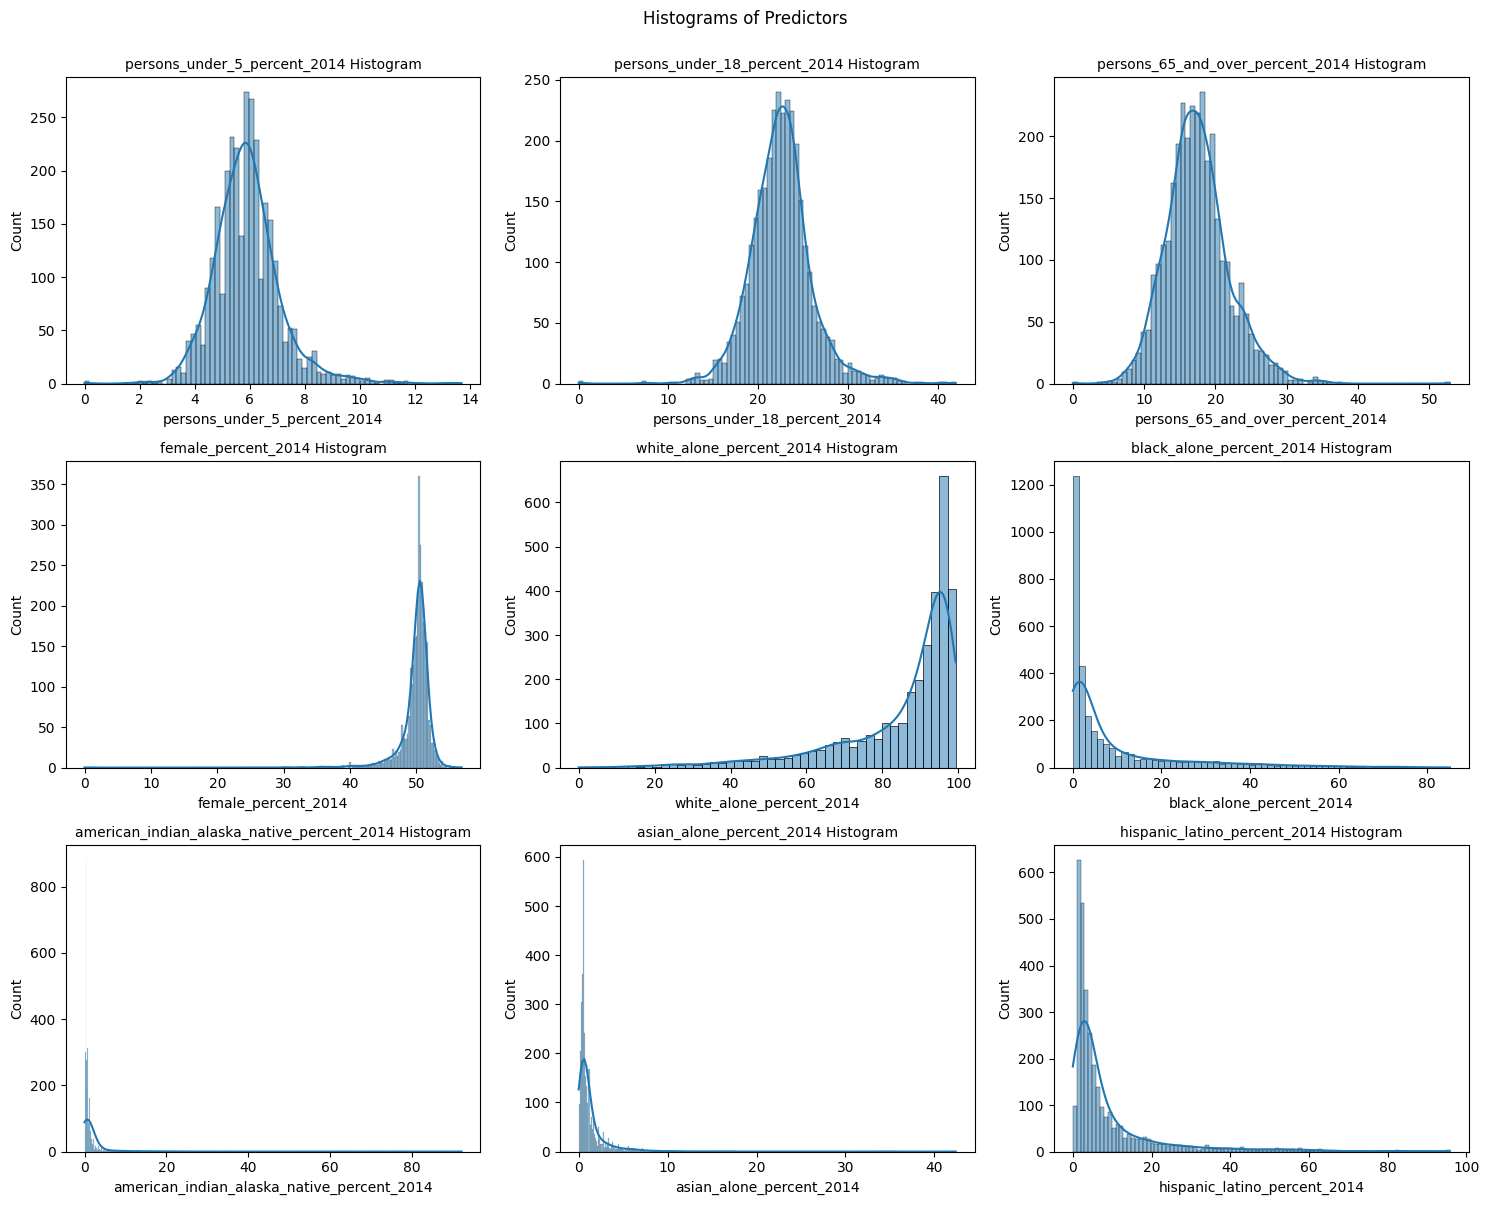

In [26]:
plot_data = county_facts[['persons_under_5_percent_2014', 'persons_under_18_percent_2014', 'persons_65_and_over_percent_2014', 'female_percent_2014', 'white_alone_percent_2014', 'black_alone_percent_2014', 'american_indian_alaska_native_percent_2014', 'asian_alone_percent_2014', 'hispanic_latino_percent_2014']]

# Create histograms for different predictors
predictor_columns = list(plot_data.columns)
num_predictors = len(predictor_columns)

# Define the number of plots per row
plots_per_row = 3

# Calculate the number of rows needed
num_rows = (num_predictors + plots_per_row - 1) // plots_per_row

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 4 * num_rows))

# Flatten the axes array to iterate over them
axes = axes.flatten()

for i, predictor_column in enumerate(predictor_columns):
    sns.histplot(data=plot_data, x=predictor_column, kde=True, ax=axes[i])
    axes[i].set_title(f'{predictor_column} Histogram', fontsize=10)

# Remove empty subplots
for i in range(num_predictors, num_rows * plots_per_row):
    fig.delaxes(axes[i])

# Adjust layout and spacing
fig.subplots_adjust(top=0.9)  # Increase the top parameter to create space for the titles

# Set common title below the subplots
fig.suptitle('Histograms of Predictors', fontsize=12, y=1.00)
plt.tight_layout()
plt.show()

While age seems to be normally distrbuted, there is signficant skewing in the other predictors.

### Republican Party Primaries

I will now look at some box plots for some predictors I think may be influential in predicting winners of the Republican Primaries

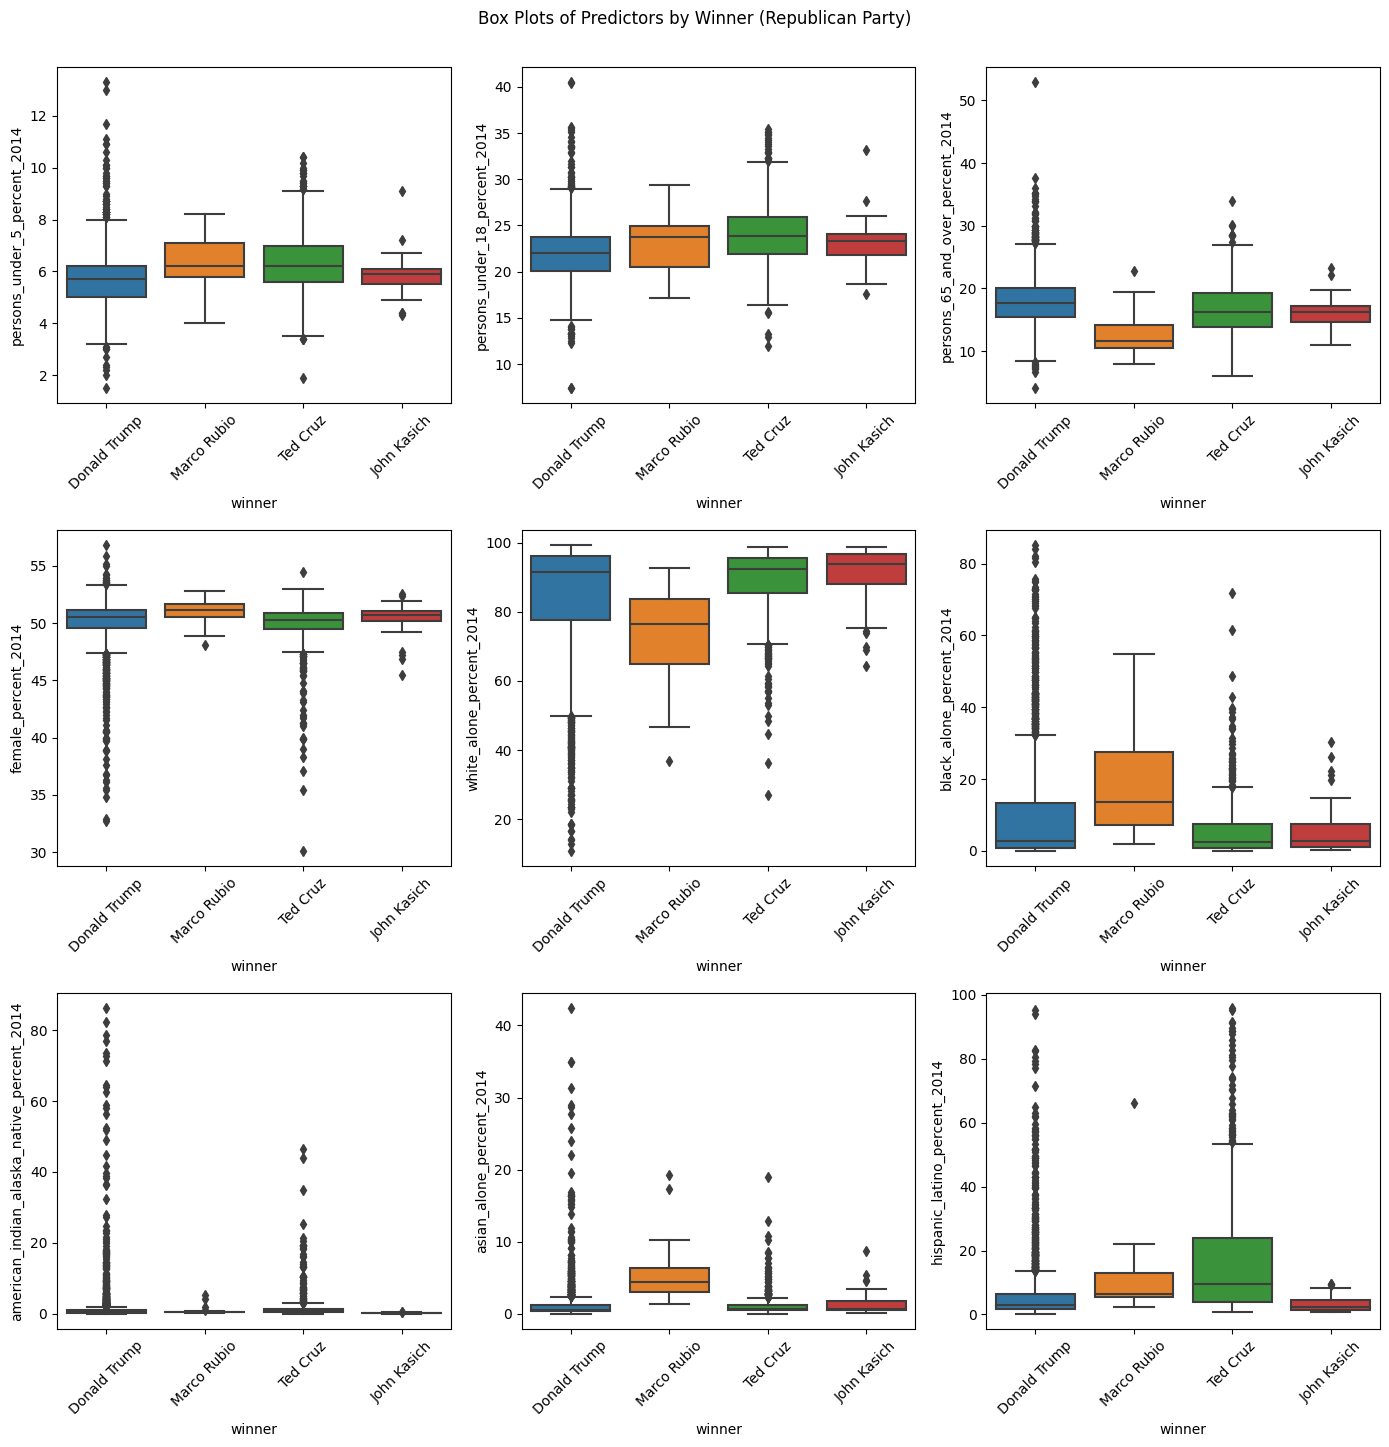

In [27]:
# Filter the DataFrame to select relevant columns for plotting
plot_data = republican_results[['winner', 'persons_under_5_percent_2014', 'persons_under_18_percent_2014', 'persons_65_and_over_percent_2014', 'female_percent_2014', 'white_alone_percent_2014', 'black_alone_percent_2014', 'american_indian_alaska_native_percent_2014', 'asian_alone_percent_2014', 'hispanic_latino_percent_2014']]

# Create box plots for relevant predictors
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 14))
sns.boxplot(x='winner', y='persons_under_5_percent_2014', data=plot_data, ax=axes[0, 0])
sns.boxplot(x='winner', y='persons_under_18_percent_2014', data=plot_data, ax=axes[0, 1])
sns.boxplot(x='winner', y='persons_65_and_over_percent_2014', data=plot_data, ax=axes[0, 2])
sns.boxplot(x='winner', y='female_percent_2014', data=plot_data, ax=axes[1, 0])
sns.boxplot(x='winner', y='white_alone_percent_2014', data=plot_data, ax=axes[1, 1])
sns.boxplot(x='winner', y='black_alone_percent_2014', data=plot_data, ax=axes[1, 2])
sns.boxplot(x='winner', y='american_indian_alaska_native_percent_2014', data=plot_data, ax=axes[2, 0])
sns.boxplot(x='winner', y='asian_alone_percent_2014', data=plot_data, ax=axes[2, 1])
sns.boxplot(x='winner', y='hispanic_latino_percent_2014', data=plot_data, ax=axes[2, 2])

# Set x-axis labels to be rotated for better readability
for ax in axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Adjust the layout and title
plt.tight_layout()
plt.suptitle('Box Plots of Predictors by Winner (Republican Party)', y=1.03)

# Show the plots
plt.show()

From these plots, it appears that Marco Rubio generally wins counties with a higher percentage of the black population compared to other candidates. However, the overlapping box plots suggest that this relationship may not be statistically significant. Similarly, Ted Cruz seems to have a tendency to win in counties with a larger Hispanic/Latino population, but again, the box plots do not provide clear evidence of statistical significance. Finally, Donald Trump appears to be more successful in counties with an older population, particularly when compared to those won by Marco Rubio. Yet, to determine if there's statistically significant evidence that he predominantly wins in older counties, a formal statistical test is required.

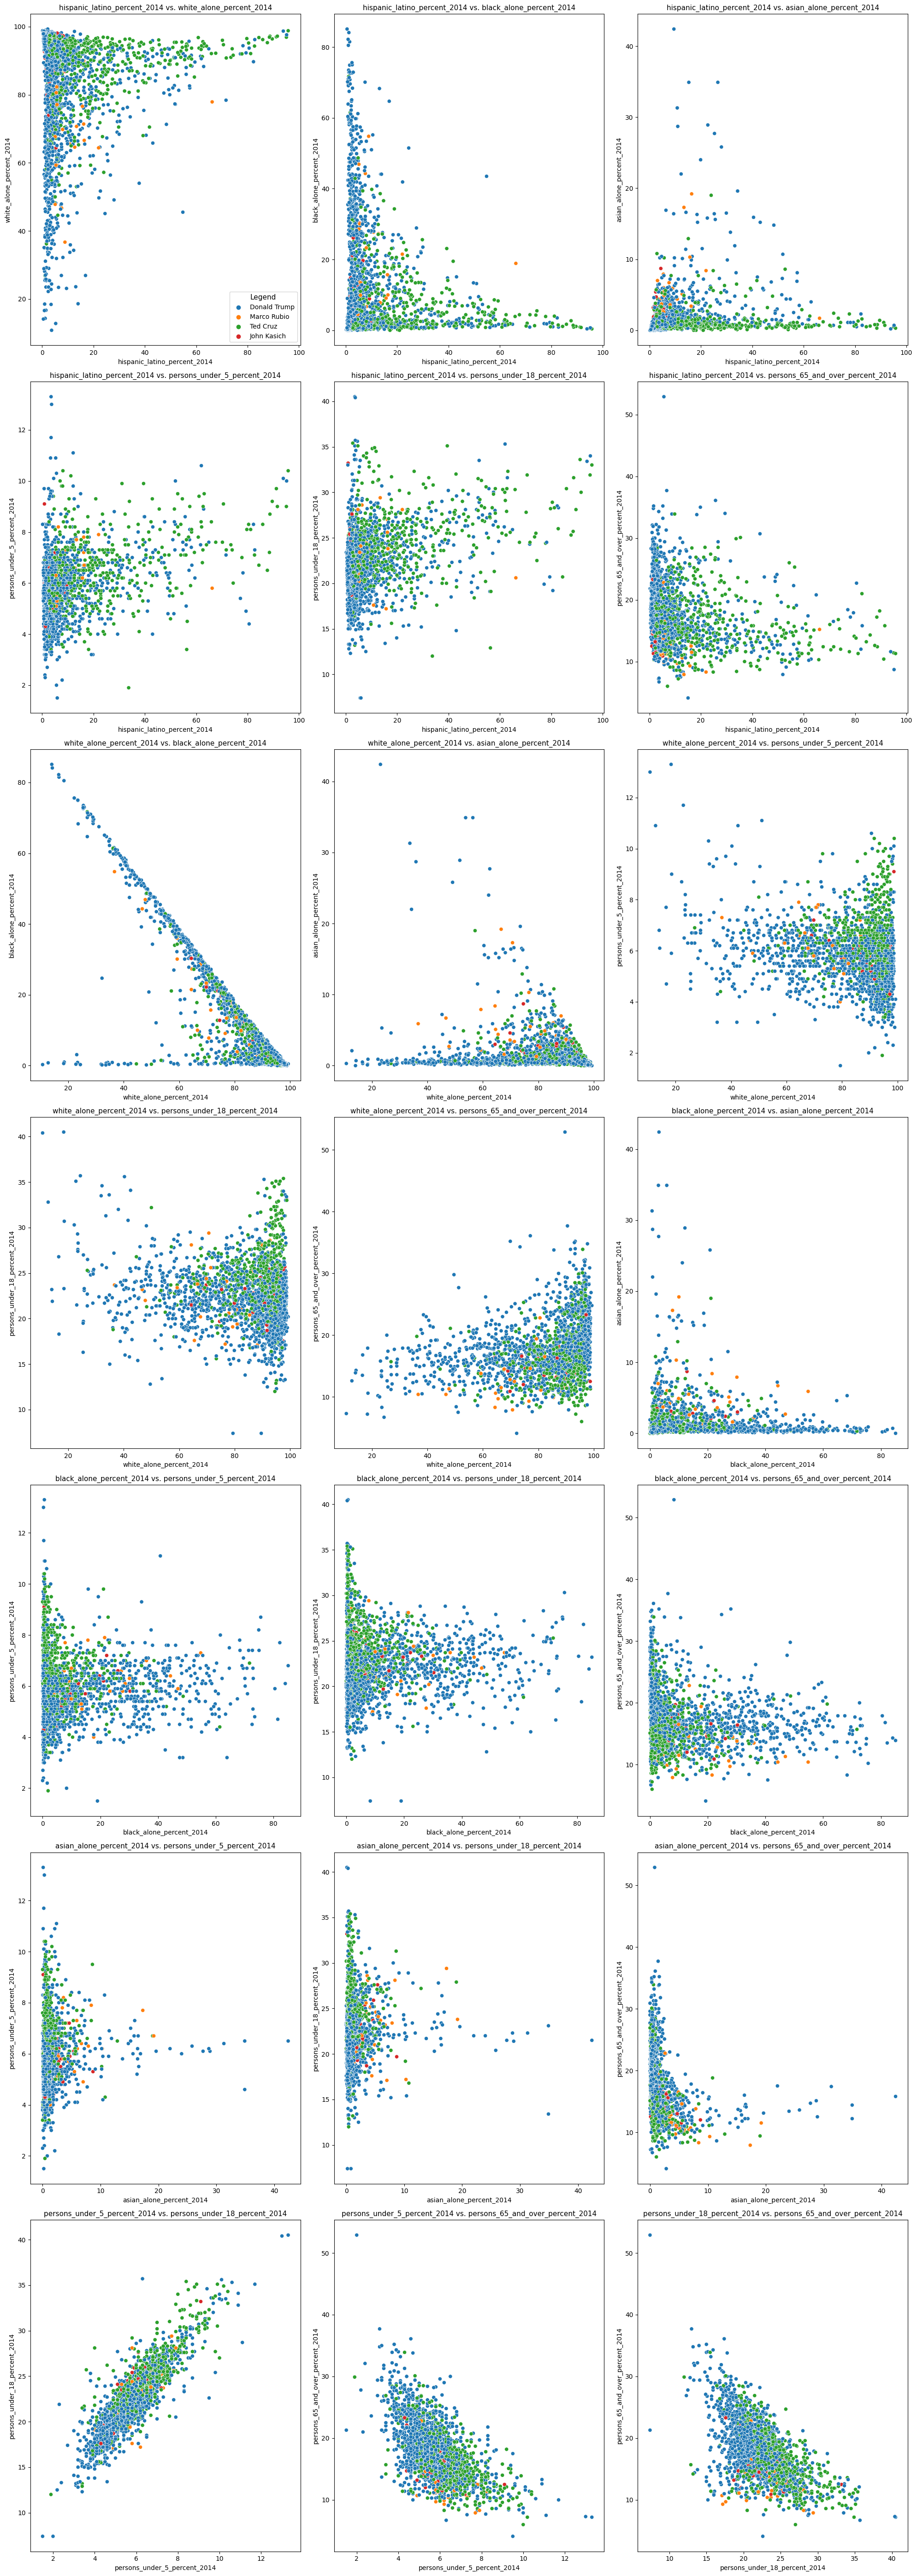

In [28]:
# Filter the DataFrame to select relevant columns for plotting
plot_data = republican_results[['winner', 'hispanic_latino_percent_2014', 'white_alone_percent_2014', 'black_alone_percent_2014', 'asian_alone_percent_2014', 'persons_under_5_percent_2014', 'persons_under_18_percent_2014', 'persons_65_and_over_percent_2014']]

# List of predictor columns
predictor_columns = ['hispanic_latino_percent_2014', 'white_alone_percent_2014', 'black_alone_percent_2014', 'asian_alone_percent_2014', 'persons_under_5_percent_2014', 'persons_under_18_percent_2014', 'persons_65_and_over_percent_2014']

# Create unique pairs of predictor columns
predictor_pairs = list(itertools.combinations(predictor_columns, 2))

# Define the number of plots per row
plots_per_row = 3

# Increase the figure size for better visibility
fig_width = 20  # Width of the figure
fig_height_per_row = 8  # Height of each row of plots

# Update the number of rows based on the number of pairs
num_rows = (len(predictor_pairs) + plots_per_row - 1) // plots_per_row

# Create a grid of plots with the updated figure size
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(fig_width, fig_height_per_row * num_rows))
axes = axes.flatten()

# Create scatter plots for each pair
first_plot = True
for i, (col1, col2) in enumerate(predictor_pairs):
    ax = axes[i]
    sns.scatterplot(x=col1, y=col2, hue='winner', data=plot_data, ax=ax)
    ax.set_title(f'{col1} vs. {col2}', fontsize=11)  # Adjust title font size
    ax.set_xlabel(col1, fontsize=10)  # Adjust x-axis label font size
    ax.set_ylabel(col2, fontsize=10)  # Adjust y-axis label font size

    if first_plot:
        # Add the legend to the first subplot only
        legend = ax.legend(title='Legend')
        legend.set_title('Legend', prop={'size': 11})  # Adjust legend title size
        first_plot = False
    else:
        ax.get_legend().remove()

# Remove any extra subplots
for i in range(len(predictor_pairs), num_rows * plots_per_row):
    fig.delaxes(axes[i])

# Adjust the layout and add space between plots
plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust the spacing between plots

plt.tight_layout()
plt.show()


A key observation is that among the evaluated Republican primary candidates, Donald Trump stands out for his stronger performance in counties with higher percentages of black and Asian populations. Additionally, he appears to have a notable appeal among older demographics. In contrast, Ted Cruz shows better performance in areas with younger populations and higher Hispanic representation.

Text(0.5, 1.0, 'Correlation Heatmap')

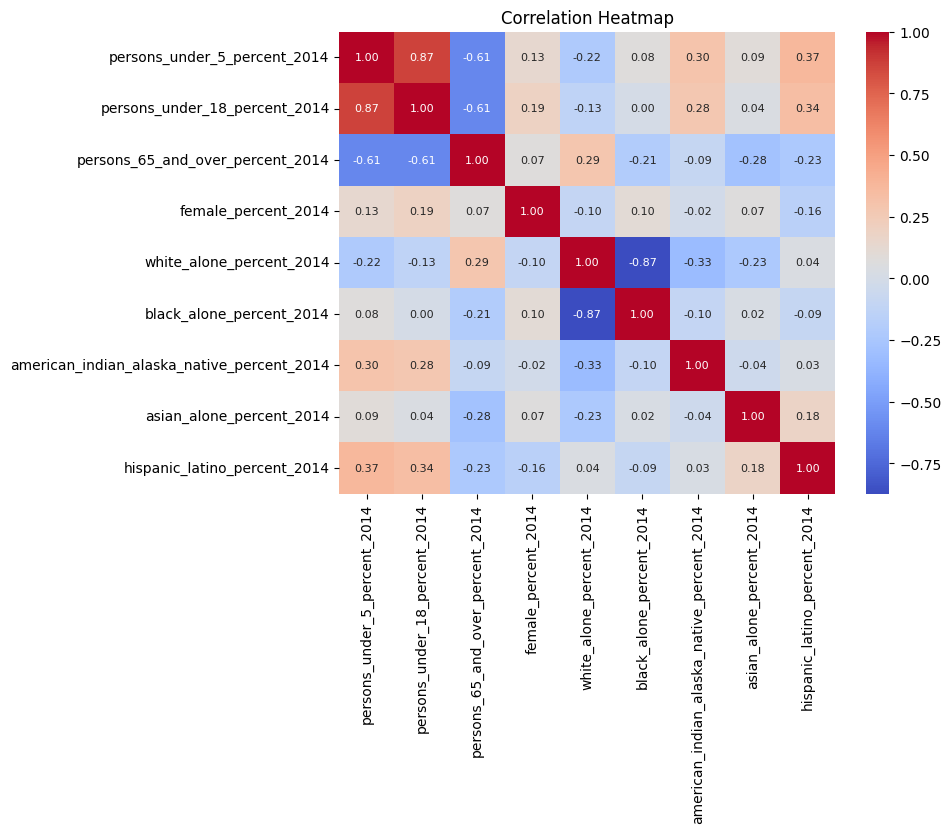

In [29]:
# Observe corelation between some county facts features (these serve as features for both republican and democrat df)
plot_data_republican = republican_results[['winner','persons_under_5_percent_2014', 'persons_under_18_percent_2014', 'persons_65_and_over_percent_2014', 'female_percent_2014', 'white_alone_percent_2014', 'black_alone_percent_2014', 'american_indian_alaska_native_percent_2014', 'asian_alone_percent_2014', 'hispanic_latino_percent_2014']]
plot_data_republican = plot_data_republican.drop('winner', axis=1)

# Calculate the correlation matrix
correlation_matrix = plot_data_republican.corr()

# Create a correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
plt.title('Correlation Heatmap', fontsize=12)

The analysis reveals minimal correlation among most of the predictors, with notable exceptions being the negative correlation of -.87 between the percentages of black and white populations, and a logical correlation (.87) observed between the proportions of persons under 5 and under 18.

### Democrat Party Primaries

/tmp/ipykernel_20/457641245.py:44: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  fig.legend(handles=legend.legendHandles, loc='upper center', bbox_to_anchor=(0.5, 1))


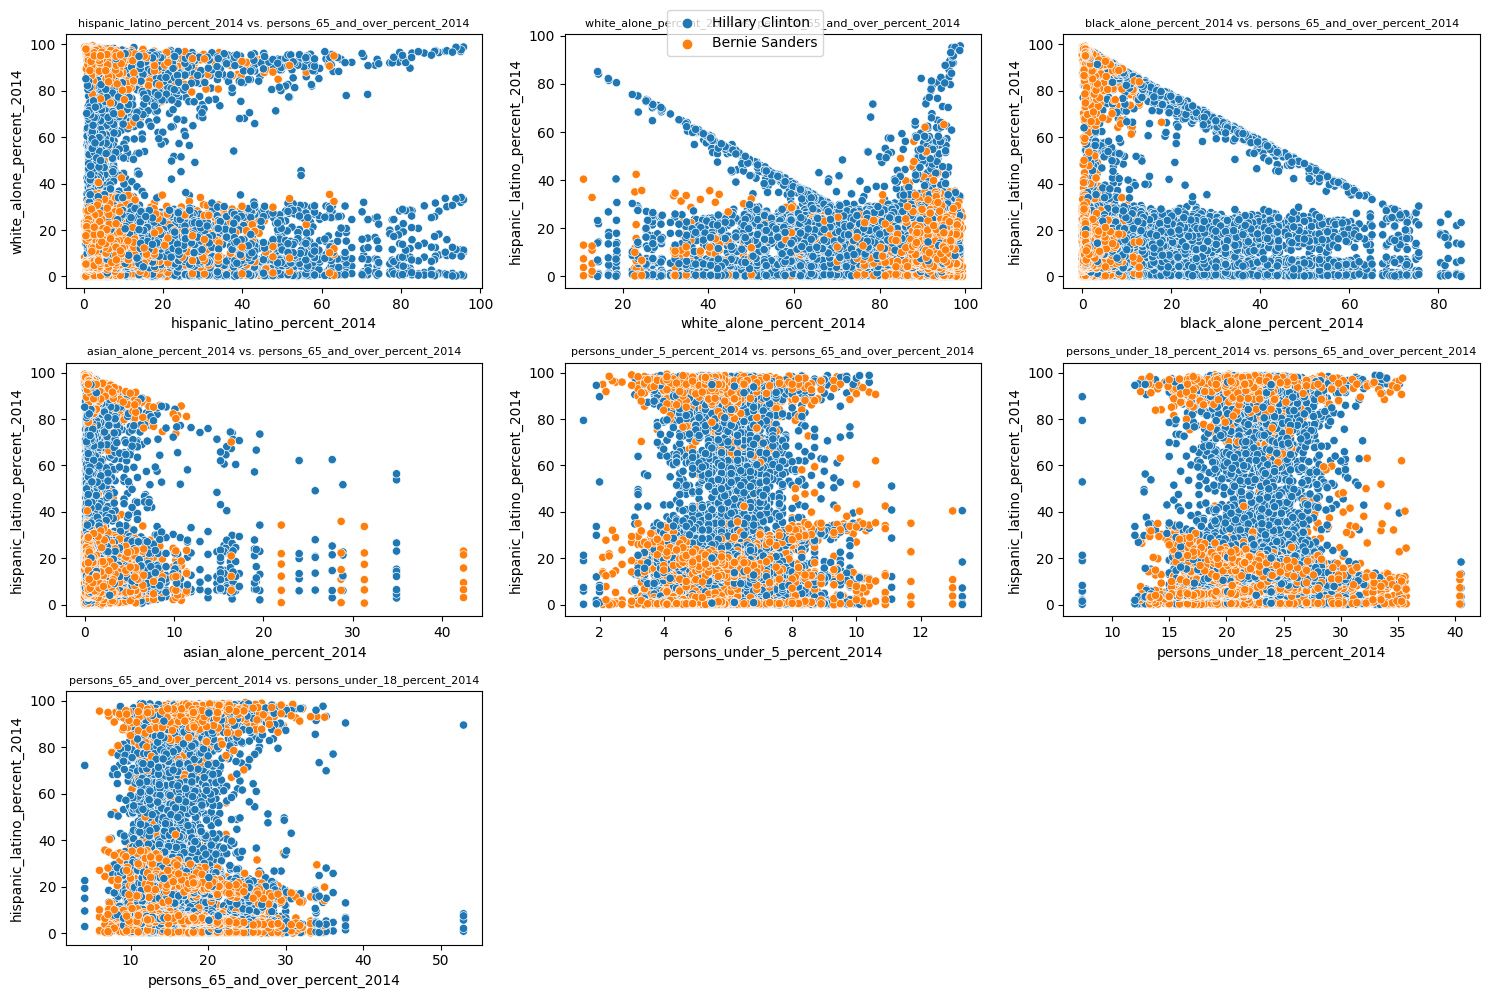

In [30]:
# Filter the DataFrame to select relevant columns for plotting
plot_data = democrat_results[['winner', 'hispanic_latino_percent_2014', 'white_alone_percent_2014', 'black_alone_percent_2014', 'asian_alone_percent_2014', 'persons_under_5_percent_2014', 'persons_under_18_percent_2014', 'persons_65_and_over_percent_2014']]

# Create scatter plots for all predictors against each other with the hue representing the winner
predictor_columns = ['hispanic_latino_percent_2014', 'white_alone_percent_2014', 'black_alone_percent_2014', 'asian_alone_percent_2014', 'persons_under_5_percent_2014', 'persons_under_18_percent_2014', 'persons_65_and_over_percent_2014']

# Define the number of plots per row and the number of rows
plots_per_row = 3
num_rows = (len(predictor_columns) + plots_per_row - 1) // plots_per_row

# Create a grid of plots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 10))

# Flatten the axes array to iterate over them
axes = axes.flatten()

# Create scatter plots
first_plot = True  # To ensure the first subplot's legend is added to the entire figure
for i, predictor_column in enumerate(predictor_columns):
    for j, other_predictor in enumerate(predictor_columns):
        if i != j:
            ax = axes[i]
            sns.scatterplot(x=predictor_column, y=other_predictor, hue='winner', data=plot_data, ax=ax)
            ax.set_title(f'{predictor_column} vs. {other_predictor}', fontsize=8)

            if first_plot:
                # Add the legend to the first subplot only and customize the legend labels
                legend = ax.legend(title='Legend')
                legend.set_title('Legend', prop={'size': 8})  # Set the legend title size
                legend.texts = [f'Winner: {value}' for value in plot_data['winner'].unique()]  # Customize legend labels
                first_plot = False
            else:
                # Remove the legend from other subplots
                ax.get_legend().remove()

# Remove empty subplots
for i in range(len(predictor_columns), num_rows * plots_per_row):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()

# Specify the placement of the legend to avoid overlap with plots
fig.legend(handles=legend.legendHandles, loc='upper center', bbox_to_anchor=(0.5, 1))

plt.show()

I will now do the same for Democrat Party primaries and identify trends or characterisitcs in the data.

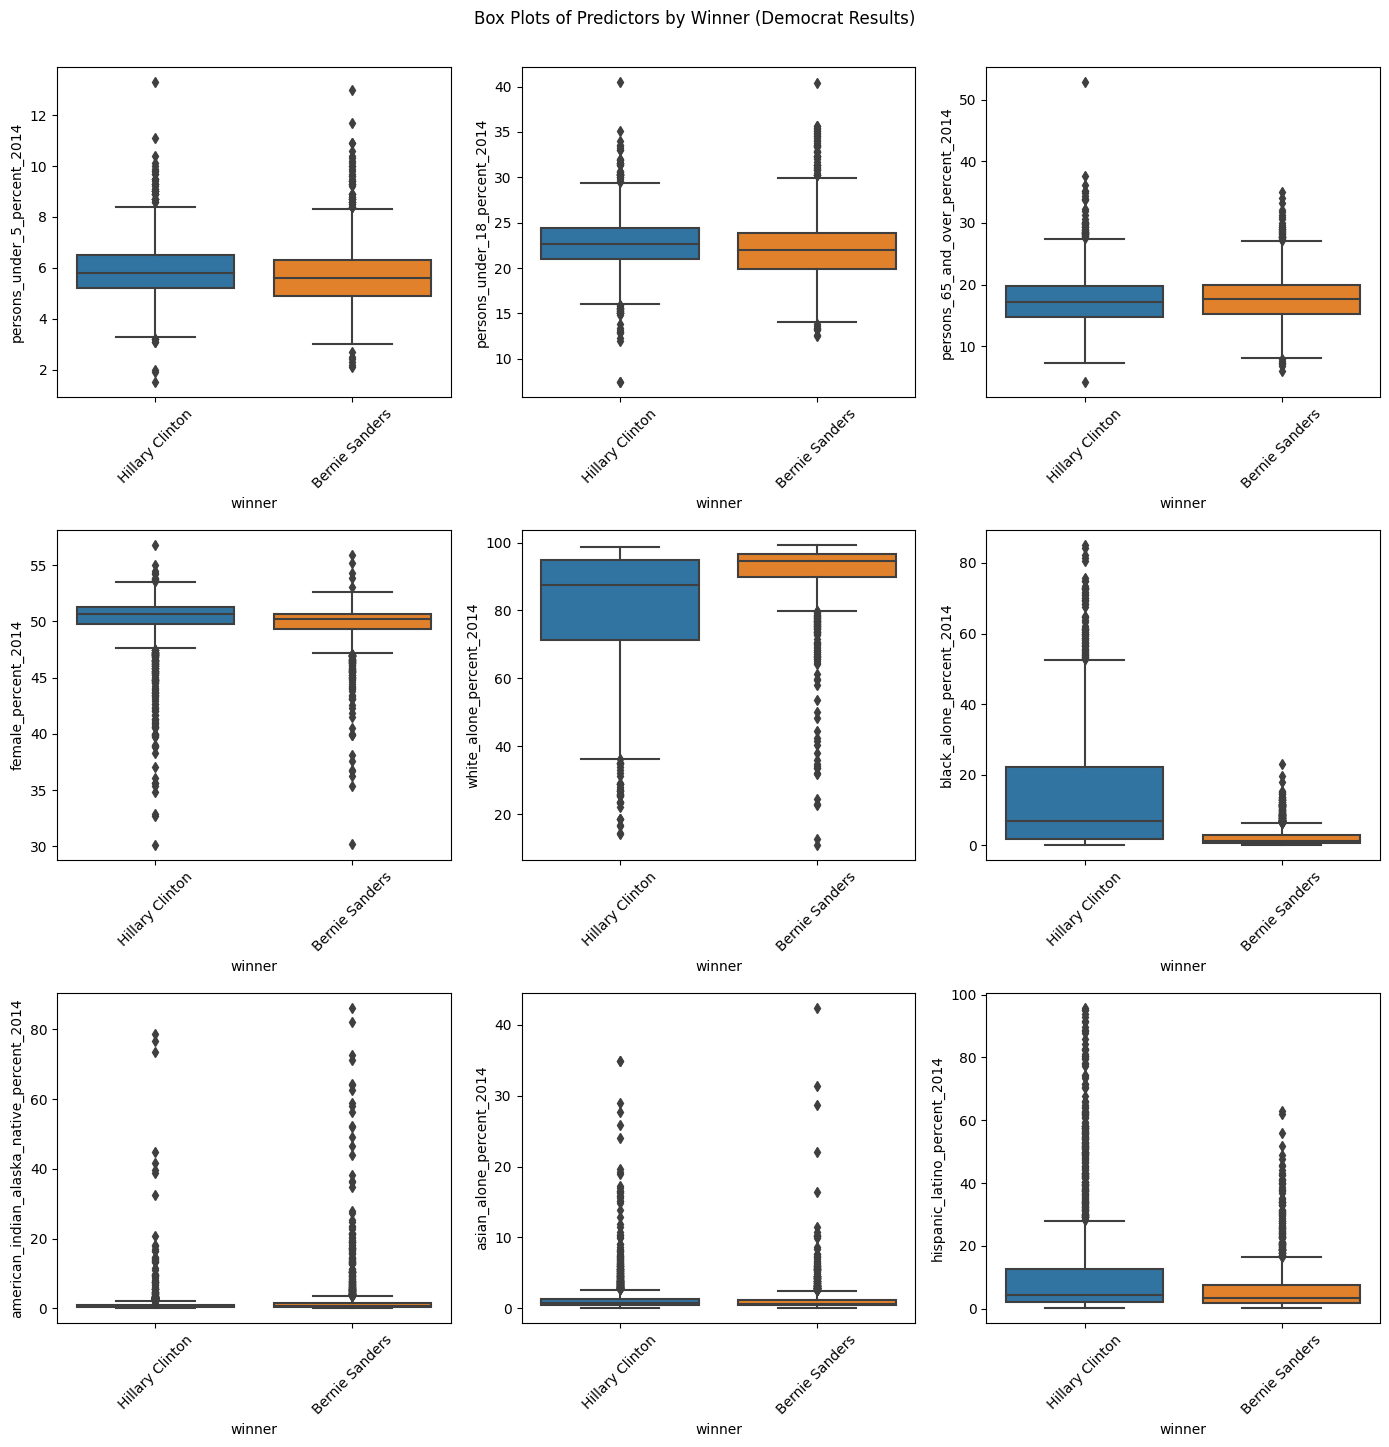

In [31]:
# Filter the DataFrame to select relevant columns for plotting
plot_data = democrat_results[['winner', 'persons_under_5_percent_2014', 'persons_under_18_percent_2014', 'persons_65_and_over_percent_2014', 'female_percent_2014', 'white_alone_percent_2014', 'black_alone_percent_2014', 'american_indian_alaska_native_percent_2014', 'asian_alone_percent_2014', 'hispanic_latino_percent_2014']]

# Create box plots for relevant predictors
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 14))
sns.boxplot(x='winner', y='persons_under_5_percent_2014', data=plot_data, ax=axes[0, 0])
sns.boxplot(x='winner', y='persons_under_18_percent_2014', data=plot_data, ax=axes[0, 1])
sns.boxplot(x='winner', y='persons_65_and_over_percent_2014', data=plot_data, ax=axes[0, 2])
sns.boxplot(x='winner', y='female_percent_2014', data=plot_data, ax=axes[1, 0])
sns.boxplot(x='winner', y='white_alone_percent_2014', data=plot_data, ax=axes[1, 1])
sns.boxplot(x='winner', y='black_alone_percent_2014', data=plot_data, ax=axes[1, 2])
sns.boxplot(x='winner', y='american_indian_alaska_native_percent_2014', data=plot_data, ax=axes[2, 0])
sns.boxplot(x='winner', y='asian_alone_percent_2014', data=plot_data, ax=axes[2, 1])
sns.boxplot(x='winner', y='hispanic_latino_percent_2014', data=plot_data, ax=axes[2, 2])

# Set x-axis labels to be rotated for better readability
for ax in axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Adjust the layout and title
plt.tight_layout()
plt.suptitle('Box Plots of Predictors by Winner (Democrat Results)', y=1.03)

# Show the plots
plt.show()


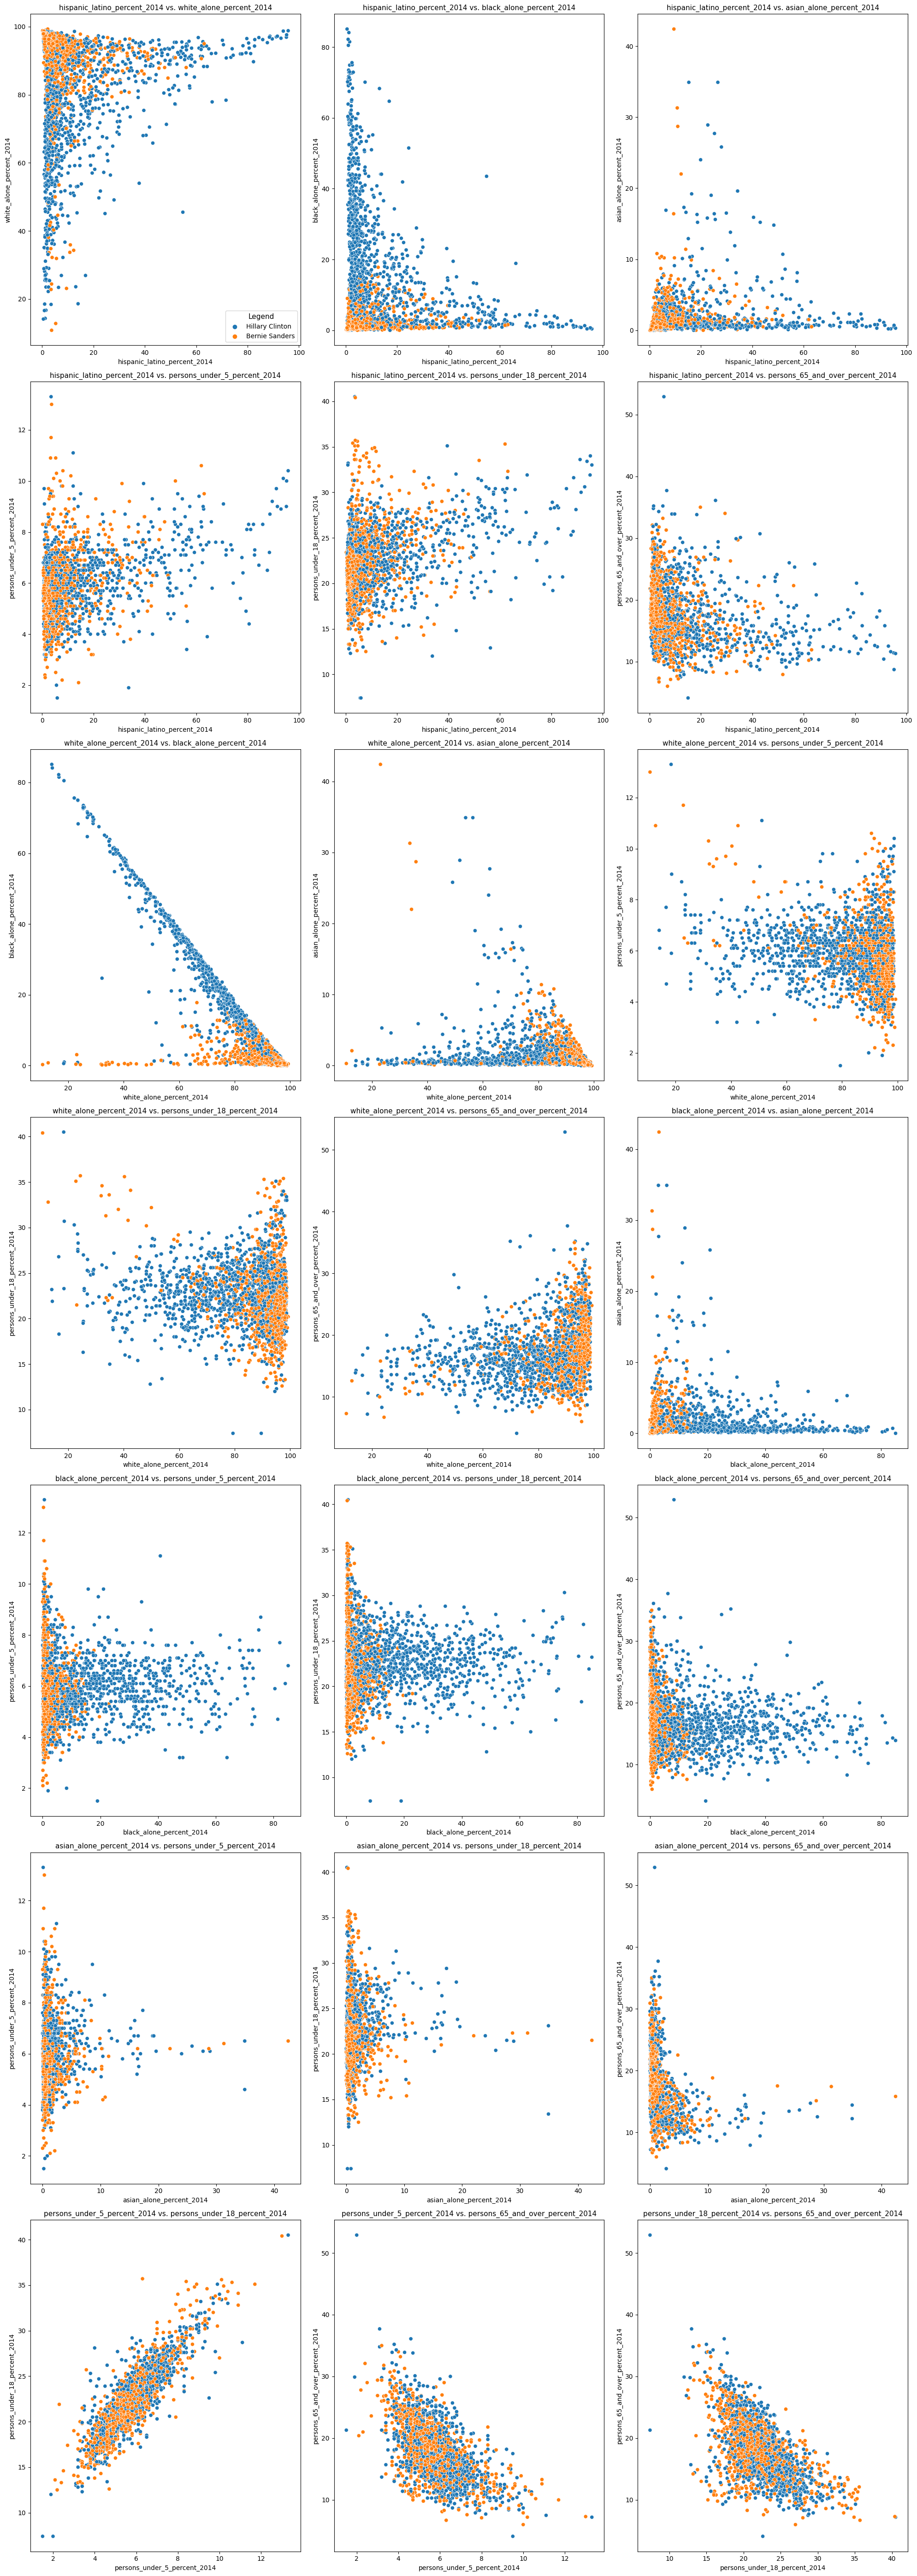

In [32]:
# Filter the DataFrame to select relevant columns for plotting
plot_data = democrat_results[['winner', 'hispanic_latino_percent_2014', 'white_alone_percent_2014', 'black_alone_percent_2014', 'asian_alone_percent_2014', 'persons_under_5_percent_2014', 'persons_under_18_percent_2014', 'persons_65_and_over_percent_2014']]

# List of predictor columns
predictor_columns = ['hispanic_latino_percent_2014', 'white_alone_percent_2014', 'black_alone_percent_2014', 'asian_alone_percent_2014', 'persons_under_5_percent_2014', 'persons_under_18_percent_2014', 'persons_65_and_over_percent_2014']

# Create unique pairs of predictor columns
predictor_pairs = list(itertools.combinations(predictor_columns, 2))

# Define the number of plots per row
plots_per_row = 3

# Increase the figure size for better visibility
fig_width = 20  # Width of the figure
fig_height_per_row = 8  # Height of each row of plots

# Update the number of rows based on the number of pairs
num_rows = (len(predictor_pairs) + plots_per_row - 1) // plots_per_row

# Create a grid of plots with the updated figure size
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(fig_width, fig_height_per_row * num_rows))
axes = axes.flatten()

# Create scatter plots for each pair
first_plot = True
for i, (col1, col2) in enumerate(predictor_pairs):
    ax = axes[i]
    sns.scatterplot(x=col1, y=col2, hue='winner', data=plot_data, ax=ax)
    ax.set_title(f'{col1} vs. {col2}', fontsize=11)  # Adjust title font size
    ax.set_xlabel(col1, fontsize=10)  # Adjust x-axis label font size
    ax.set_ylabel(col2, fontsize=10)  # Adjust y-axis label font size

    if first_plot:
        # Add the legend to the first subplot only
        legend = ax.legend(title='Legend')
        legend.set_title('Legend', prop={'size': 11})  # Adjust legend title size
        first_plot = False
    else:
        ax.get_legend().remove()

# Remove any extra subplots
for i in range(len(predictor_pairs), num_rows * plots_per_row):
    fig.delaxes(axes[i])

# Adjust the layout and add space between plots
plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust the spacing between plots

plt.tight_layout()
plt.show()

A big observation is that Hillary Clinton predominantly wins in counties with a significantly higher black population compared to those won by Bernie Sanders. This trend is somewhat mirrored in counties with larger Hispanic populations, where Clinton also tends to prevail, albeit to a lesser extent than with the black demographic. Conversely, Bernie Sanders is more likely to secure victories in counties where the white population is relatively higher than in those won by Hillary Clinton.

Text(0.5, 1.0, 'Correlation Heatmap')

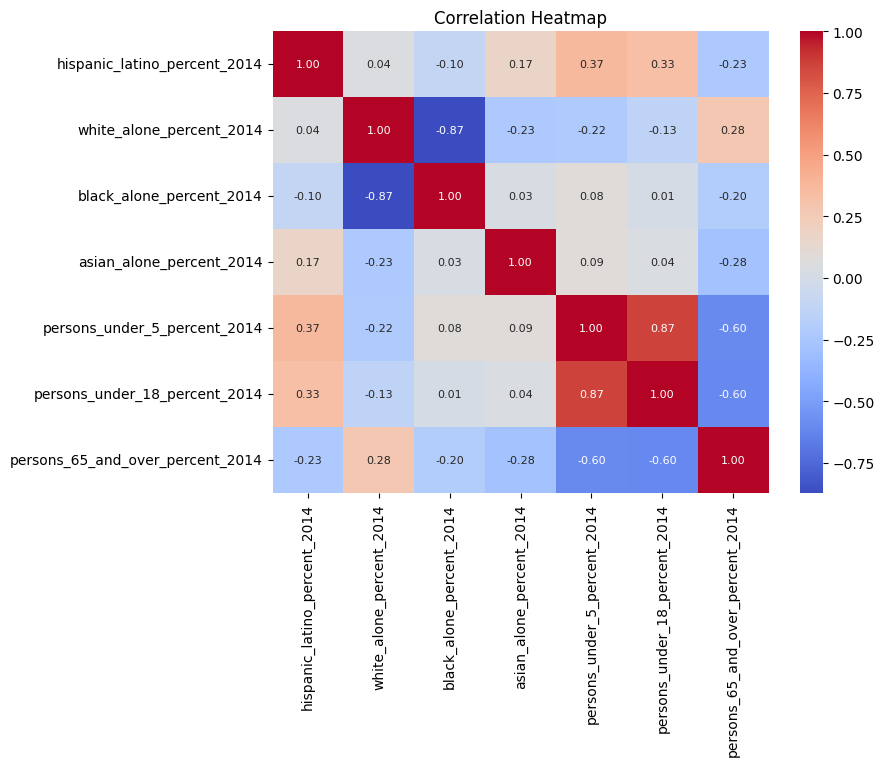

In [33]:
# Remove the 'winner' column to calculate correlation
plot_data = plot_data.drop('winner', axis=1)

# Calculate the correlation matrix
correlation_matrix = plot_data.corr()

# Create a correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
plt.title('Correlation Heatmap', fontsize=12)

The analysis reveals minimal correlation among most of the predictors, with notable exceptions being the negative correlation of -.87 between the percentages of black and white populations, and a logical correlation (.87) observed between the proportions of persons under 5 and under 18.

# Create Models and Evaluate

For this next part, I will create a couple of different models, evaulate them, and choose the model with the highest performance accuracy.

I will now use an 80-20 split to create testing and training sets for both dataframes, and remove the labels from the set (this will become the y column).

First, I will do it for the Republican dataframe.

In [34]:
# Create features data frame and label dataframe
X_republican = republican_results.drop(columns=["winner"])
y_republican = republican_results["winner"]

# Split the Republican dataset into training and testing (80-20 split) with fixed random state for replicability
X_train_republican, X_test_republican, y_train_republican, y_test_republican = train_test_split(
    X_republican, y_republican, test_size=0.2, random_state=42)

# Remove non-numeric columns from the Republican dataset (the county and state_abbreviation are not features)
X_train_republican = X_train_republican.drop(columns=["county", "state_abbreviation"])
X_test_republican = X_test_republican.drop(columns=["county", "state_abbreviation"])

# Remove vote and votes columns (these are not features)
X_train_republican = X_train_republican.drop(columns=["Vote", "votes"])
X_test_republican = X_test_republican.drop(columns=["Vote", "votes"])

Now, I will do it for the Democrat dataframe.

In [35]:
# Create features data frame and label dataframe
X_democrat = democrat_results.drop(columns=["winner"])
y_democrat = democrat_results["winner"]

# Split the Democrat dataset into training and testing (80-20 split) with fixed random state for replicability
X_train_democrat, X_test_democrat, y_train_democrat, y_test_democrat = train_test_split(
    X_democrat, y_democrat, test_size=0.2, random_state=42, stratify = y_democrat)

# Remove non-numeric columns from the Democrat dataset (the county and state_abbreviation are not features)
X_train_democrat = X_train_democrat.drop(columns=["county", "state_abbreviation"])
X_test_democrat = X_test_democrat.drop(columns=["county", "state_abbreviation"])

# Remove vote and votes columns (these are not features)
X_train_democrat = X_train_democrat.drop(columns=["Vote", "votes"])
X_test_democrat = X_test_democrat.drop(columns=["Vote", "votes"])

I will now scale the data in order to improve convergence speed and testing accuracy in the soon to be created logistic regression model.

First, with the republican dataframe.

In [36]:
# Create a StandardScaler
scaler = StandardScaler()

# Prepare Republican dataset
X_train_republican = scaler.fit_transform(X_train_republican)
X_test_republican = scaler.transform(X_test_republican)

# Create a Logistic Regression model for the Republican party (increase max_iter to ensure convergence)
glm_republican = LogisticRegression(max_iter = 1000)

# Fit the model with the scaled data
glm_republican.fit(X_train_republican, y_train_republican)

LogisticRegression(max_iter=1000)

I will also create models with regularization to try and improve performance.

First with L1 Regularization.

In [37]:
# Create a Logistic Regression model with L1 regularization
# You can adjust the regularization strength with the 'C' parameter (lower values mean stronger regularization)
glm_republican_lasso = LogisticRegression(penalty='l1', C=.01, solver='liblinear', max_iter=1000)

# Fit the model with the scaled data
glm_republican_lasso.fit(X_train_republican, y_train_republican)

LogisticRegression(C=0.01, max_iter=1000, penalty='l1', solver='liblinear')

Next with L2 Regularization.

In [38]:
# Create a Logistic Regression model with L2 regularization
# You can adjust the regularization strength with the 'C' parameter (lower values mean stronger regularization)
glm_republican_ridge = LogisticRegression(penalty='l2', C=.01, solver='lbfgs', max_iter=1000)

# Fit the model with the scaled data
glm_republican_ridge.fit(X_train_republican, y_train_republican)

LogisticRegression(C=0.01, max_iter=1000)

Next, with the democrat dataframe.

In [39]:
# Prepare Democrat dataset
X_train_democrat = scaler.fit_transform(X_train_democrat)
X_test_democrat = scaler.transform(X_test_democrat)

# Create a Logistic Regression model for the Democrat party (increase max_iter to ensure convergence)
glm_democrat = LogisticRegression(max_iter = 1000)

# Fit the model with the scaled data
glm_democrat.fit(X_train_democrat, y_train_democrat)

LogisticRegression(max_iter=1000)

I will also create logistic regression models with regularization for the democrat dataset.

In [40]:
# Create a Logistic Regression model with L1 regularization
# You can adjust the regularization strength with the 'C' parameter (lower values mean stronger regularization)
glm_democrat_lasso = LogisticRegression(penalty='l1', C=.01, solver='liblinear', max_iter=1000)

# Fit the model with the scaled data
glm_democrat_lasso.fit(X_train_democrat, y_train_democrat)

LogisticRegression(C=0.01, max_iter=1000, penalty='l1', solver='liblinear')

In [41]:
# Create a Logistic Regression model with L2 regularization
# You can adjust the regularization strength with the 'C' parameter (lower values mean stronger regularization)
glm_democrat_ridge = LogisticRegression(penalty='l2', C=.01, solver='lbfgs', max_iter=1000)

# Fit the model with the scaled data
glm_democrat_ridge.fit(X_train_democrat, y_train_democrat)

LogisticRegression(C=0.01, max_iter=1000)

To have a more robust understanding of the performance of the model, I will apply cross-validation.

In [42]:
# Define the number of folds (e.g., 5)
n_splits = 5

In [43]:
cv_scores_republican_glm = cross_val_score(glm_republican, X_train_republican, y_train_republican, cv=n_splits)
cv_scores_republican_glm_lasso = cross_val_score(glm_republican_lasso, X_train_republican, y_train_republican, cv=n_splits)
cv_scores_republican_glm_ridge = cross_val_score(glm_republican_ridge, X_train_republican, y_train_republican, cv=n_splits)

In [44]:
cv_scores_democrat_glm = cross_val_score(glm_democrat, X_train_democrat, y_train_democrat, cv=n_splits)
cv_scores_democrat_glm_lasso = cross_val_score(glm_democrat_lasso, X_train_democrat, y_train_democrat, cv=n_splits)
cv_scores_democrat_glm_ridge = cross_val_score(glm_democrat_ridge, X_train_democrat, y_train_democrat, cv=n_splits)

In [45]:
# Evaluate the models with cross-validated accuracy scores
mean_cv_score_republican_glm = cv_scores_republican_glm.mean()
mean_cv_score_republican_glm_lasso= cv_scores_republican_glm_lasso.mean()
mean_cv_score_republican_glm_ridge = cv_scores_republican_glm_ridge.mean()
mean_cv_score_democrat_glm = cv_scores_democrat_glm.mean()
mean_cv_score_democrat_glm_lasso = cv_scores_democrat_glm_lasso.mean()
mean_cv_score_democrat_glm_ridge = cv_scores_democrat_glm_ridge.mean()


print("Cross-Validated Accuracy (GLM) - Republican:", mean_cv_score_republican_glm)
print("Cross-Validated Accuracy (GLM) - Republican with lasso regularization:", mean_cv_score_republican_glm_lasso)
print("Cross-Validated Accuracy (GLM) - Republican with ridge regularization:", mean_cv_score_republican_glm_ridge)
print("Cross-Validated Accuracy (GLM) - Democrat:", mean_cv_score_democrat_glm)
print("Cross-Validated Accuracy (GLM) - Democrat with lasso regularization:", mean_cv_score_democrat_glm_lasso)
print("Cross-Validated Accuracy (GLM) - Democrat with ridge regularization:", mean_cv_score_democrat_glm_ridge)

Cross-Validated Accuracy (GLM) - Republican: 0.8096188214002942
Cross-Validated Accuracy (GLM) - Republican with lasso regularization: 0.7639215020925234
Cross-Validated Accuracy (GLM) - Republican with ridge regularization: 0.7924816197262752
Cross-Validated Accuracy (GLM) - Democrat: 0.7871559633027523
Cross-Validated Accuracy (GLM) - Democrat with lasso regularization: 0.721559633027523
Cross-Validated Accuracy (GLM) - Democrat with ridge regularization: 0.7724770642201835


Both models tend to perform best without any regularization.

## Model Prediction Accuracy

In [46]:
# Make predictions on the test sets
glm_predictions_republican = glm_republican.predict(X_test_republican)
glm_predictions_democrat = glm_democrat.predict(X_test_democrat)
# Make predictions with L1 Regularization on the test sets
glm_predictions_republican_lasso = glm_republican_lasso.predict(X_test_republican)
glm_predictions_democrat_lasso = glm_democrat_lasso.predict(X_test_democrat)
# Make predictions with L2 Regularization on the test sets
glm_predictions_republican_ridge = glm_republican_ridge.predict(X_test_republican)
glm_predictions_democrat_ridge = glm_democrat_ridge.predict(X_test_democrat)

In [47]:
# Evaluate model accuracy on the test sets
glm_accuracy_republican = accuracy_score(y_test_republican, glm_predictions_republican)
glm_accuracy_democrat = accuracy_score(y_test_democrat, glm_predictions_democrat)
# Evaluate model accuracy on the test sets with L1 Regularization
glm_accuracy_republican_lasso = accuracy_score(y_test_republican, glm_predictions_republican_lasso)
glm_accuracy_democrat_lasso = accuracy_score(y_test_democrat, glm_predictions_democrat_lasso)
# Evaluate model accuracy on the test sets with L2 Regularization
glm_accuracy_republican_ridge = accuracy_score(y_test_republican, glm_predictions_republican_ridge)
glm_accuracy_democrat_ridge = accuracy_score(y_test_democrat, glm_predictions_democrat_ridge)

print("GLM Model Accuracy (Republican):", glm_accuracy_republican)
print("GLM Model Accuracy (Democrat):", glm_accuracy_democrat)
print("GLM Model Accuracy with lasso (Republican):", glm_accuracy_republican_lasso)
print("GLM Model Accuracy with lasso (Democrat):", glm_accuracy_democrat_lasso)
print("GLM Model Accuracy with ridge(Republican):", glm_accuracy_republican_ridge)
print("GLM Model Accuracy with ridge (Democrat):", glm_accuracy_democrat_ridge)

# Generate classification reports for test set predictions
print("GLM Model Classification Report (Republican):\n", classification_report(y_test_republican, glm_predictions_republican))
print("GLM Model Classification Report (Democrat):\n", classification_report(y_test_democrat, glm_predictions_democrat))
# Generate classification reports for test set predictions with lasso
print("GLM Model Classification Report with lasso (Republican):\n", classification_report(y_test_republican, glm_predictions_republican_lasso))
print("GLM Model Classification Report with lasso (Democrat):\n", classification_report(y_test_democrat, glm_predictions_democrat_lasso))
# Generate classification reports for test set predictions with ridge
print("GLM Model Classification Report with ridge (Republican):\n", classification_report(y_test_republican, glm_predictions_republican_ridge))
print("GLM Model Classification Report with ridge (Democrat):\n", classification_report(y_test_democrat, glm_predictions_democrat_ridge))

GLM Model Accuracy (Republican): 0.7813688212927756
GLM Model Accuracy (Democrat): 0.8018348623853211
GLM Model Accuracy with lasso (Republican): 0.7129277566539924
GLM Model Accuracy with lasso (Democrat): 0.7339449541284404
GLM Model Accuracy with ridge(Republican): 0.7642585551330798
GLM Model Accuracy with ridge (Democrat): 0.7871559633027523
GLM Model Classification Report (Republican):
               precision    recall  f1-score   support

Donald Trump       0.79      0.94      0.86       369
 John Kasich       0.43      0.18      0.25        17
 Marco Rubio       0.25      0.25      0.25         4
    Ted Cruz       0.78      0.43      0.56       136

    accuracy                           0.78       526
   macro avg       0.56      0.45      0.48       526
weighted avg       0.77      0.78      0.76       526

GLM Model Classification Report (Democrat):
                  precision    recall  f1-score   support

 Bernie Sanders       0.76      0.80      0.78       237
Hillary C

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

The model accuracy is rather low for the republican logistic models, but ~80% for democrat logistic model without regularization. I will try to improve performance using a xgbboostclassifier. I will then choose the models with the best accuracy.

To choose the best parameters, I will run grid search for each xgboosted model.

For the republican model:

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Encode the target variable
y_train_encoded = label_encoder.fit_transform(y_train_republican)

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300, 400],  # Extend the range of n_estimators.
    'max_depth': list(range(3, 11)),  # Wider range for max_depth.
    'learning_rate': [0.01, 0.1, 0.2, 0.3],  # Include more learning rates.
}

# Define the XGBoost model
xgb_model_republican = xgb.XGBClassifier()

# Perform GridSearchCV with XGBoost
grid_search_republican = GridSearchCV(
    xgb_model_republican,  # Use the XGBoost model
    param_grid=param_grid,
    cv=5,  # You can adjust the number of folds based on your dataset size.
    n_jobs=-1,
)

# Fit the model and find the best hyperparameters
grid_search_republican.fit(X_train_republican, y_train_encoded)  # Use the encoded target variable

best_params_republican = grid_search_republican.best_params_

Using these best parameters, I will intialize the XGBoost model with these hyperparameters for the Republican party.

In [49]:
# Encode the test target
y_test_encoded_republican = label_encoder.fit_transform(y_test_republican)

# Initialize the XGBoost model with the best hyperparameters
best_xgb_model_republican = xgb.XGBClassifier(
    n_estimators=best_params_republican['n_estimators'],
    max_depth=best_params_republican['max_depth'],
    learning_rate=best_params_republican['learning_rate']
)

# Train the model on the training data
best_xgb_model_republican.fit(X_train_republican, y_train_encoded)

# Make predictions on the test data
y_pred_republican = best_xgb_model_republican.predict(X_test_republican)

# Calculate and display the accuracy
accuracy = accuracy_score(y_test_encoded_republican, y_pred_republican)
print("Accuracy: {:.2f}%".format(accuracy * 100))


Accuracy: 84.03%


This testing accuracy was better (~84%) than simply using a logistic regression model,

I will now do the exact same thing for the democrat model:

In [50]:
# Encode the target variable
y_train_encoded_democrat = label_encoder.fit_transform(y_train_democrat)

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300, 400],  # Extend the range of n_estimators.
    'max_depth': list(range(3, 11)),  # Wider range for max_depth.
    'learning_rate': [0.01, 0.1, 0.2, 0.3],  # Include more learning rates.
}

# Define the XGBoost model
xgb_model_democrat = xgb.XGBClassifier()

# Perform GridSearchCV with XGBoost
grid_search = GridSearchCV(
    xgb_model_democrat,  # Use the XGBoost model
    param_grid=param_grid,
    cv=5,  # You can adjust the number of folds based on your dataset size.
    n_jobs=-1,
)

# Fit the model and find the best hyperparameters
grid_search.fit(X_train_democrat, y_train_encoded_democrat)  # Use the encoded target variable

best_params_democrat = grid_search.best_params_

In [51]:
# Encode the target variable
y_test_encoded_democrat = label_encoder.fit_transform(y_test_democrat)

# Initialize the XGBoost model with the best hyperparameters
xgb_model_democrat = xgb.XGBClassifier(
    n_estimators=best_params_democrat['n_estimators'],
    max_depth=best_params_democrat['max_depth'],
    learning_rate=best_params_democrat['learning_rate']
)

# Train the model on the training data
xgb_model_democrat.fit(X_train_democrat, y_train_encoded_democrat)

# Make predictions on the test data
y_pred_democrat = xgb_model_democrat.predict(X_test_democrat)

# Calculate and display the accuracy
accuracy = accuracy_score(y_test_encoded_democrat, y_pred_democrat)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 79.27%


# Recommendation

In evaluating the various models developed, the most accurate one for predicting Republican outcomes was achieved using XGBoost, tuned with optimized hyperparameters through grid-search, resulting in 84% testing accuracy. On the Democrat side, the model that performed best surprisingly turned out to be logistic regression without any regularization, demonstrating a solid 80% testing accuracy.